## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II
# Micro-Proyecto 1

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

A continuación escriba los nombres de los integrantes del grupo.

Nombres: Cindy Zulima Alzate Roman, Jahir Stevens Rodriguez Riveros, Sergio Alberto Mora Pardo.


### Introducción
Una *start-up* agrícola quiere construir una aplicación online que conecte el campo
con la ciudad de manera directa y sin intermediarios. De esta manera, los agricultores ponen a la disposición de la empresa sus distintos productos, y la start-up se encarga de atender las necesidades de demanda distribuyendo los productos hasta los clientes finales en la ciudad.

Para optimizar la gestión logística y desarrollar esta labor de manera eficiente, los dueños de la *start-up* han visto la necesidad de diseñar e implementar un sistema de gestión y predicción que les permita planear con la debida anticipación la demanda esperada. Así podrán coordinar las actividades de producción, junto con los agricultores, y atender la demanda mientras se minimizan las pérdidas por unidades de producto no vendido o estropeado. 

Este es un reto altamente relevante para la sostenibilidad de la industria alimentaria, donde gran cantidad de las pérdidas se refieren a grupos alimenticios donde la frescura del producto es un importante criterio para el consumo. El desperdicio de los alimentos se relaciona con el sobre-pedido o el sobre-almacenamiento, lo cual puede a su vez ser consecuencia de dificultades en el pronóstico de la demanda. Este problema es aun más marcado a medida que uno sube en la cadena de producción y se aleja de los patrones de comportamiento del consumidor final. 

Por lo tanto, la start-up agrícola debe gestionar los inventarios de manera inteligente, disminuyendo la ventana de tiempo entre cosecha y consumo. Para ello, necesita desarrollar modelos de predicción de demanda que apoyen su operación, logrando la disponibilidad de los productos para atender a los clientes del día siguiente, minimizando los desperdicios de alimentos e identificando hábitos de consumo que le permita optimizar sus operaciones logísticas y de negocio.

### Enunciado
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un modelo predictivo de demanda para los productos más relevantes con los que trabaja la start-up agrícola, obteniendo una predicción a nivel semanal (una semana adelante). Los datos los encuentra en el archivo DatosAgro.txt, donde se tiene la identificación del cliente, la fecha en que realizó el pedido, la magnitud del pedido (en unidades según lo especificado en el nombre del producto), su precio, y el código del producto agrícola que consta en el pedido.

## 1. Visualicemos los datos

In [237]:
import pandas as pd
import numpy as np 
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import missingno as msno
import optuna

from prettytable import PrettyTable

import os
#os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import src.config
import src.models
import src.create_folds


import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import keras
import keras.backend as K
from keras.preprocessing import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM
from keras import layers

import tensorflow as tf

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)


from IPython.display import display, Markdown

In [57]:
# Importemos los datos y visualizemos la serie de tiempo
data = pd.read_csv("../input/DatosAgro.txt", delimiter='\t', encoding="utf8")
data = data.drop('Unnamed: 6', 1)
data.head()

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
0,Cliente26,18/09/2017,20,700,VER0049,Yerbabuena / 100 gramos
1,Cliente26,18/09/2017,10,1200,FRU0024,Limón Tahití / Libra
2,Cliente26,18/09/2017,4,1600,VER0041,Puerro / Libra
3,Cliente26,18/09/2017,10,1500,VER0038,Pimentón Rojo / Libra
4,Cliente26,18/09/2017,8,1100,VER0010,Zucchini Verde / Libra


Veamos los clientes con mayor participación en la demanda:

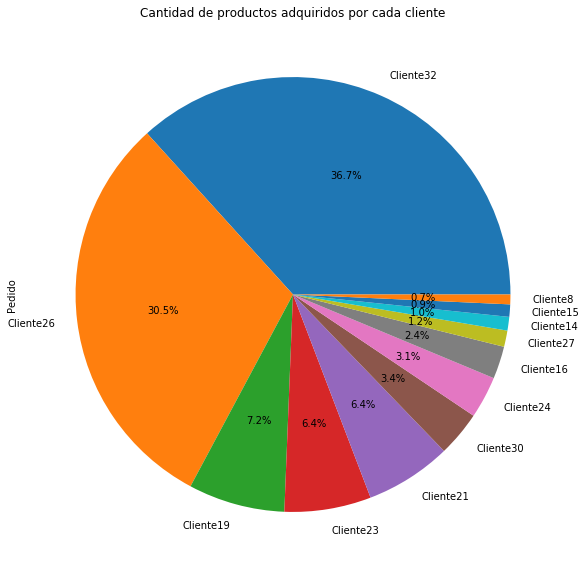

In [3]:
cliente = pd.DataFrame(data[data['Pedido'] > 10].groupby(data["Cliente"]).sum())
cliente2 = cliente[cliente['Pedido']>50]
cliente3 = cliente2.sort_values("Pedido", ascending= False)
cliente3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%')
plt.title("Cantidad de productos adquiridos por cada cliente")
plt.show()

Vemaos los productos con más volumen de pedido:

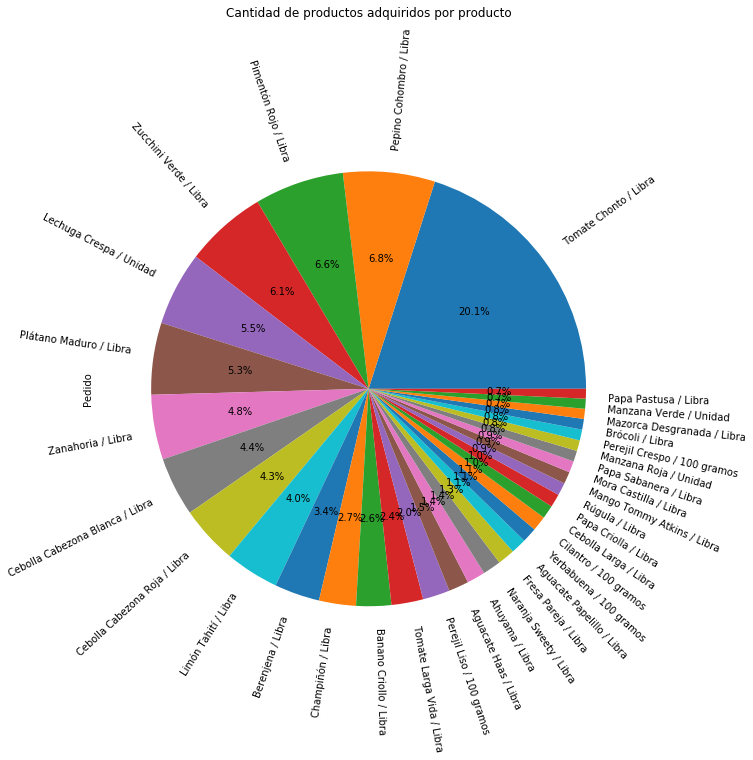

In [47]:
productos = pd.DataFrame(data["Pedido"].groupby(data["Nombre_producto"]).sum())
productos2 = productos[productos['Pedido']>140]
productos3 = productos2.sort_values("Pedido", ascending= False)
productos3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%', rotatelabels=True)
plt.title("Cantidad de productos adquiridos por producto", pad=100)
plt.show()

A continuación implemente la metodología propuesta para construir su modelo:

**Analísis Exploratorio de Datos**
* ¿Cuantos productos tenemos?
* ¿Cúantos clientes tenemos?
* ¿Cúales son los principales clientes?
* ¿Qué es lo que más compran los principales clientes?
* ¿Cúantos días tenemos?
* ¿Que día de la semana más venden?
* ¿Que més piden más productos?
* ¿Qué clientes son los que compran los productos más vendidos? ¿Hay relación con los clientes que más compran?
* ¿Cúal es la distribución de precios que compran lo clientes? ¿Entre más caro más se compra o viceversa?
* ¿Los precios fluctuan por producto o siempre manejan los mismos? ¿sí fluctuan, porqué lo hacen: depende del cliente o de la fecha?

**Ingeniería de características**

* ¿Valdrá la pena sacar el valor total de la compra? (precio x cantidad)
* ¿Valdrá la pena sacar el día de la semana de las fechas?
* ¿Valdrá la pena sacar el mes de la fecha?
* ¿Valdrá la pena sacar el año de la fecha?
* ¿Valdrá la pena sacar la semana del año de la fecha?
* ¿Valdrá la pena dividir el nombre del producto entre '/'? -> se podría sacar unidad por producto (gramos, libras,...) -> si tienen número estas unidades ¿es posible sacar el número?
* ¿De la división anterior, es posible sacar el nombre del producto?

In [3]:
data.head()

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
0,Cliente26,18/09/2017,20,700,VER0049,Yerbabuena / 100 gramos
1,Cliente26,18/09/2017,10,1200,FRU0024,Limón Tahití / Libra
2,Cliente26,18/09/2017,4,1600,VER0041,Puerro / Libra
3,Cliente26,18/09/2017,10,1500,VER0038,Pimentón Rojo / Libra
4,Cliente26,18/09/2017,8,1100,VER0010,Zucchini Verde / Libra


In [4]:
print(f' Tenemos {len(data.Cliente.unique())} clientes y tenemos {len(data.Fecha.unique())} días diferentes. También tenemos {len(data.Producto.unique())} productos')

 Tenemos 34 clientes y tenemos 242 días diferentes. También tenemos 121 productos


Se maneja, una alta cardinalidad en las variables categoricas. Así mismo, la única variable no continua que tiene orden. Es la fecha.

---

**Clientes**

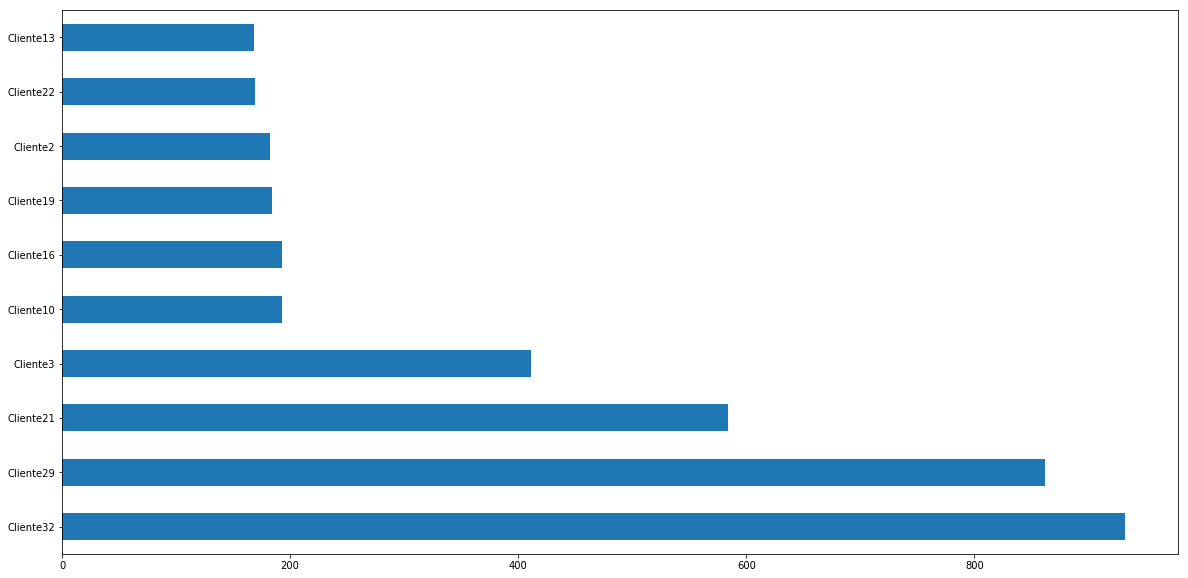

In [34]:
# ¿cúal es el clientes que más compras ha hecho?
data.Cliente.value_counts()[:10].plot(kind = 'barh', Se maneja, una alta cardinalidad en las variables categoricas. Así mismo, la única variable no continua que tiene orden. Es la fecha.)

Los 5 clientes que más compras hacen son: 32, 29, 21, 3 y 10

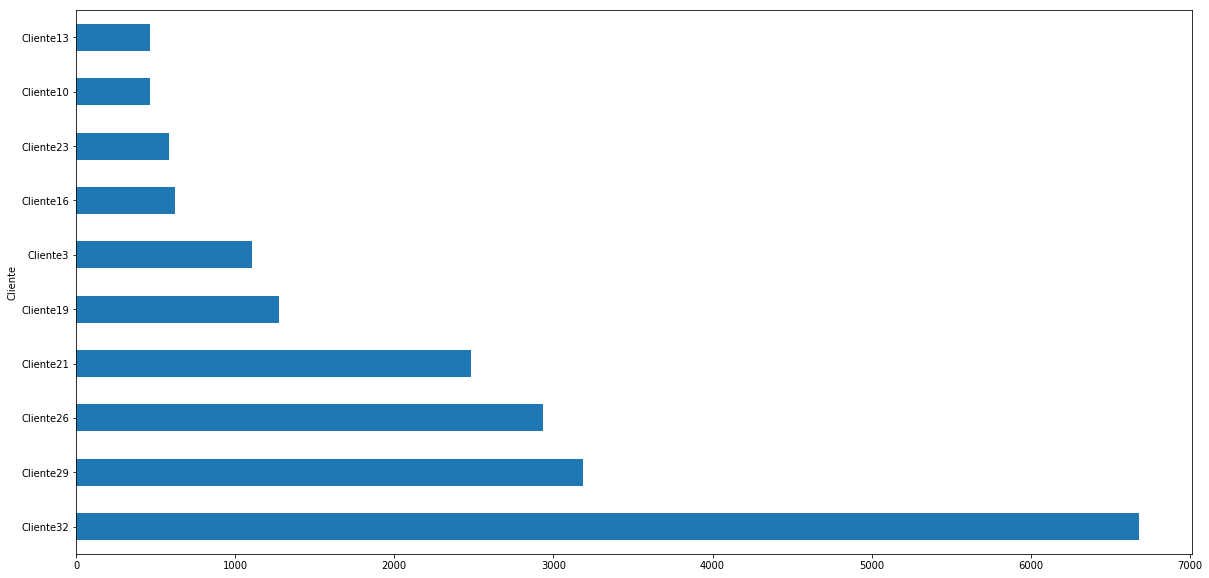

In [33]:
# ¿Cuales son los 5 clientes que más productos nos han comprado?
data.groupby('Cliente').Pedido.agg(np.sum).sort_values(ascending = False)[:10].plot(kind = 'barh', figsize = (20, 10))

Los 5 clientes que más pedidos han hecho son 32, 29, 26, 21 y 19

---

**Hipótesis**
¿Existen dos tipos de clientes? Los que compran muchas veces y poco. vs los que compran pocas veces y mucho.

In [35]:
temp = pd.merge(data.groupby('Cliente').Pedido.agg(np.sum), 
         data.Cliente.value_counts(), 
         how = 'left', left_index=True, right_index=True)

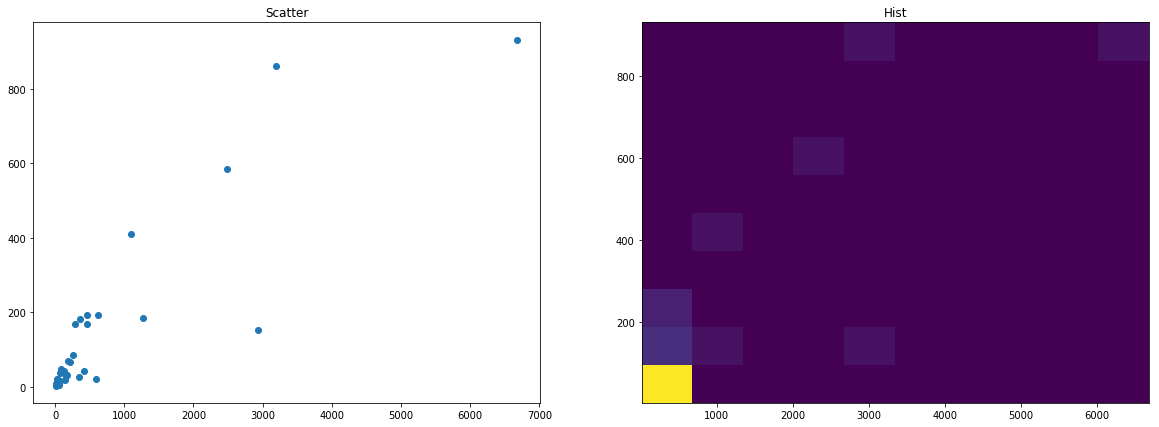

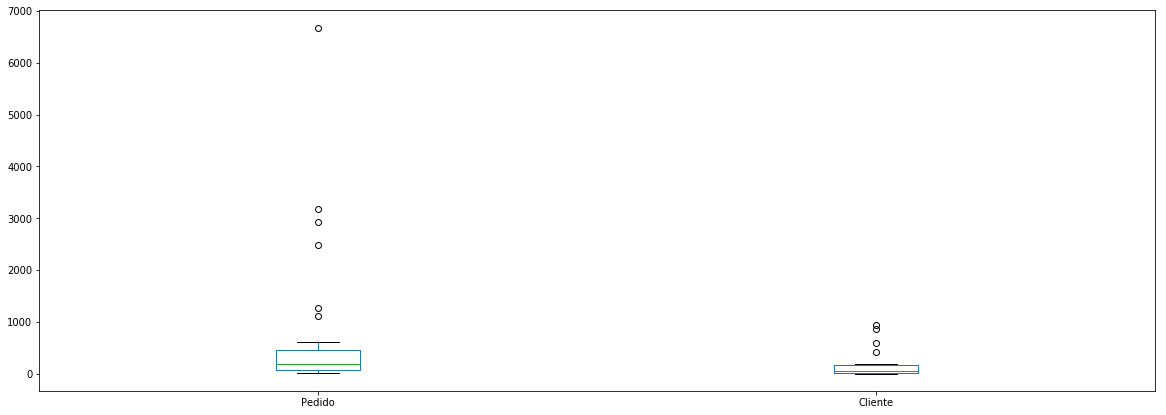

In [56]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (20, 7))
ax1.scatter(temp.Pedido, temp.Cliente)
ax1.set_title('Scatter')
ax2.hist2d(temp.Pedido, temp.Cliente)
ax2.set_title('Hist')
temp.plot(kind = 'box', figsize = (20, 7))

Como apreciamos, vemos que tenemos aproximadamente 5 clientes que tienen un comportamiento no esperado. Debido a que por observar los gráficos, existe una varianza constante entre el número de pedidos con el número de registros de los clientes. Estos 5 clientes que representan una alta cantidad de pedidos, indican que hacen muchos pedidos y muchas veces.

(array([22.,  5.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  2.]),
 array([  4. ,  96.8, 189.6, 282.4, 375.2, 468. , 560.8, 653.6, 746.4,
        839.2, 932. ]),
 <a list of 10 Patch objects>)

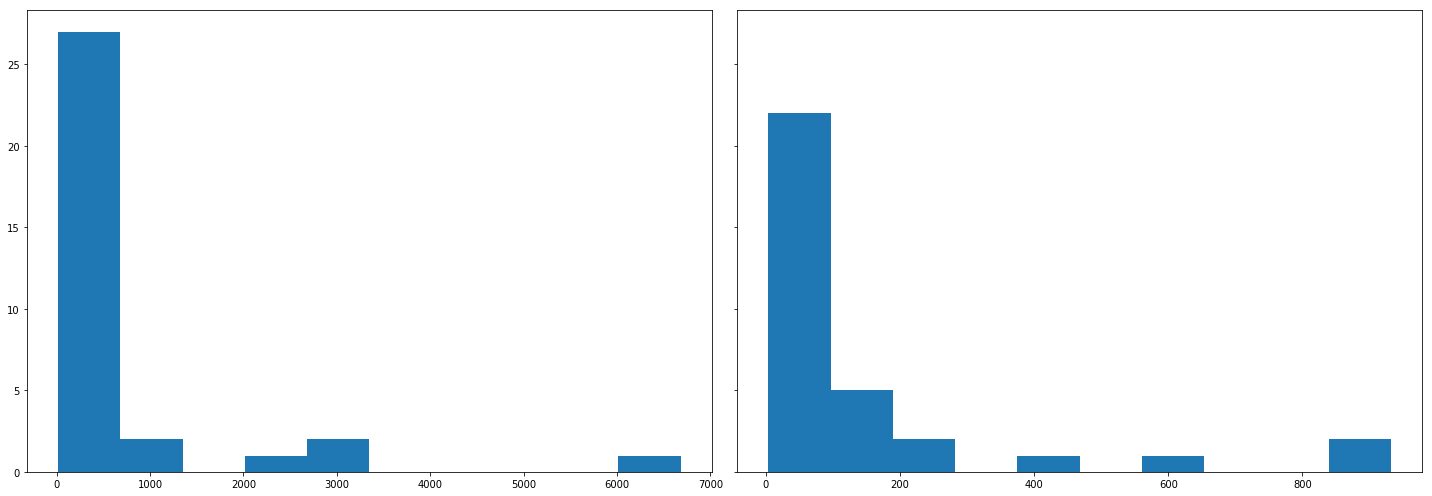

In [66]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize = (20, 7))
axs[0].hist(temp.Pedido, bins=10)
axs[1].hist(temp.Cliente, bins=10)

Probamos con dos histogramas para validar la similitud entre el número de regiostros de un cliente con el número de pedidos. Efectivamente, encontramos que existen algunos que se alejan, donde parece ser que hay clientes que se tienen hasta 800 registros de un cliente y pedidos de más de 6000 unidades a través de todo el periodo observado. Sí esto no es el comportamiento normal de los clientes. ¿cúal es el comportamiento de la mayoría de los clientes?

/u01/Anaconda/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/u01/Anaconda/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


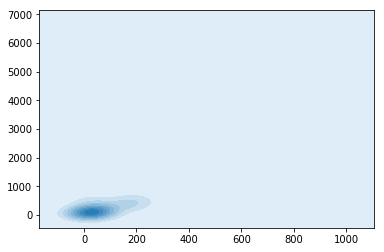

In [71]:
sns.distplot(temp[['Cliente', 'Pedido']], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = temp.columns)

El comportamiento, de la mayoría de los clientes: En todo el tiempo observado con los datos, sus cantidades en pedidos sumados no es mayor a 1.000 y la cantidad de registros de los clientes es de máximo 250.

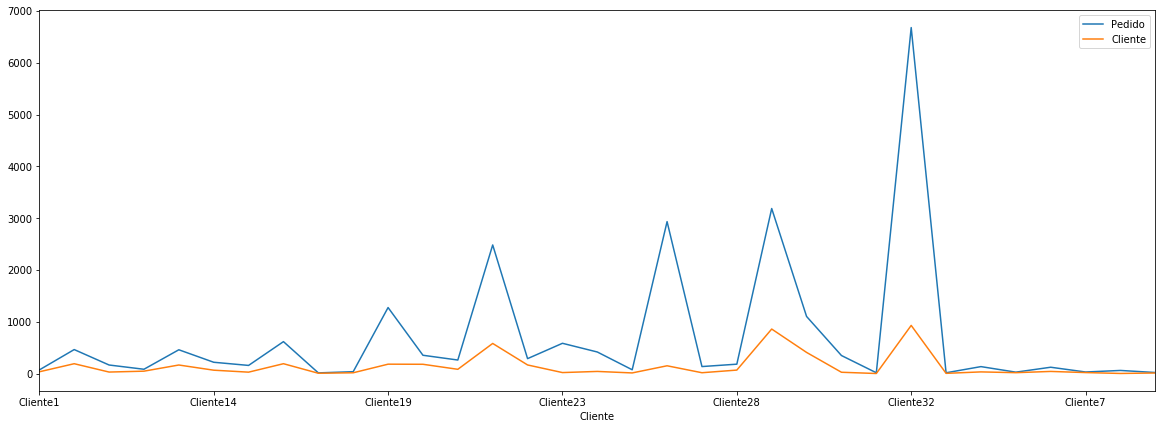

In [73]:
temp.plot(figsize = (20, 7))

Efectivamente, como se esperaba. El número de registros de un cliente no necesariamente se acerca a la suma de sus pedidos. 
Pero esto, solo pasa con pocos clientes. Especificamente con 4 clientes: 32, 28, 23 y 19. 

Es decir, el comportamiento de estos 4 clientes, no es similar al comportamiento de los demás clientes. Por ejemplo, vemos que el cliente 32 hizó más de 6.000 unidades sumadas de productos. Pero tiene cerca de 1.000 registros. Esto nos lleva a pensar ¿Cúantos es la suma de pedidos que tenemos por registros de clientes?

In [74]:
temp['PedidosxRegistro'] = temp.Pedido / temp.Cliente

In [75]:
temp.PedidosxRegistro.describe()

count    33.000000
mean      5.314008
std       5.470001
min       1.500000
25%       2.166667
50%       3.207254
75%       5.333333
max      26.681818
Name: PedidosxRegistro, dtype: float64

Como vemos. Al extraer el coeficiente entre la suma de los pedidos por cleinte contra el número de registros del cliente. Tenemos, que por cada resgistro que se hace por cliente en promedio se espera que se comprén 5 productos. Existen algunos que llegan a peir hasta 26 productos por registro. 

*Nota*: 
* La desviación de pedidos es de 5 productos.
* A continuación historama de Pedidos por registro.

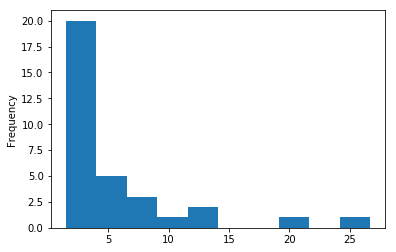

In [78]:
temp.PedidosxRegistro.plot(kind = 'hist')

---

**Precio**

Antes de revisar las fechas, revisaremos la dinámica del precio. Revisemos su distribución.

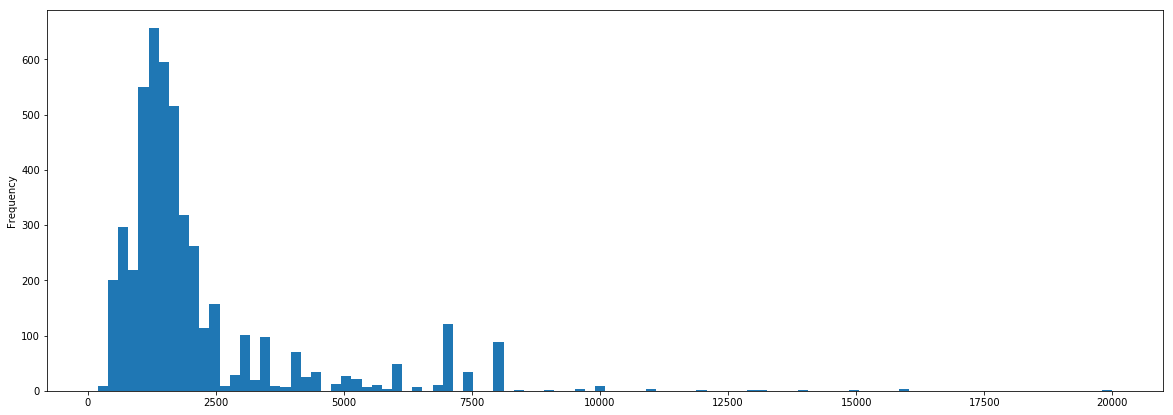

In [86]:
data.Precio.plot.hist(figsize = (20, 7), bins = 100)

In [92]:
data.Precio.describe()

count     4712.000000
mean      2065.488115
std       1823.445580
min        200.000000
25%       1100.000000
50%       1500.000000
75%       2000.000000
max      20000.000000
Name: Precio, dtype: float64

El promedio de los precios es cercano a los 2000. Con una mediana de 1500; es decir, que el precio más recurrente en los productos es de 1500. Existen productos que pueden costar hasta 20000. sin embargo, son muy pocos. En contraste, también tenemos productos de 200 pero estos son poco consumidos igualmente.

**hipotésis:**

¿Entre más económico el producto, más pedido es?

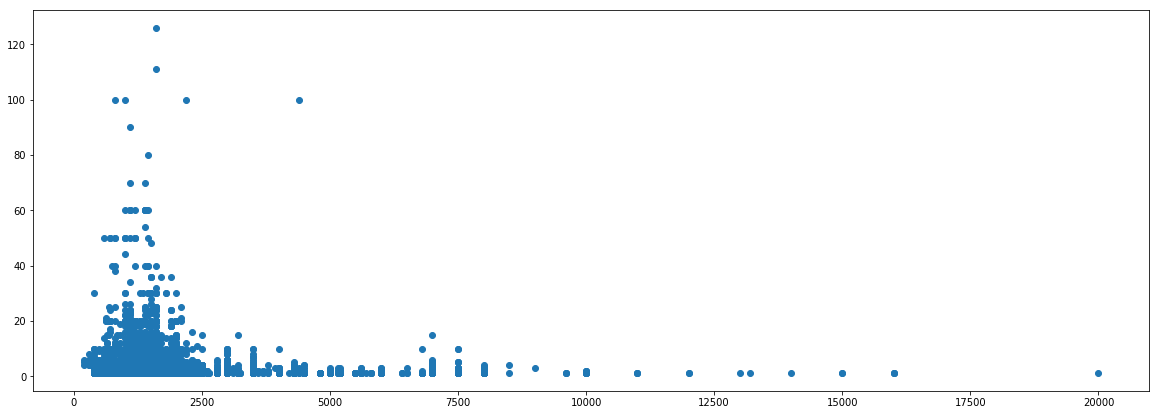

In [89]:
plt.figure(figsize = (20, 7))
plt.scatter(data.Precio, data.Pedido)
plt.show()

Como vemos. No necesariamente, por que un producto sea más económico, será más comprado. Vemos que existen pedidos con cantidades de hasta 120 productos con precios de hasta 2500. Así mismo, vemos pocos productos, que llegan a costar hasta 20000.

---

**Fecha**

Como vemos que la tarea final, es realizar un pronóstico. Nos enfocaremos acá para nuestro análisis. Vemos, desde lo básico:



In [116]:
data.Fecha.describe()

count           4712
unique           242
top       07/02/2017
freq              97
Name: Fecha, dtype: object

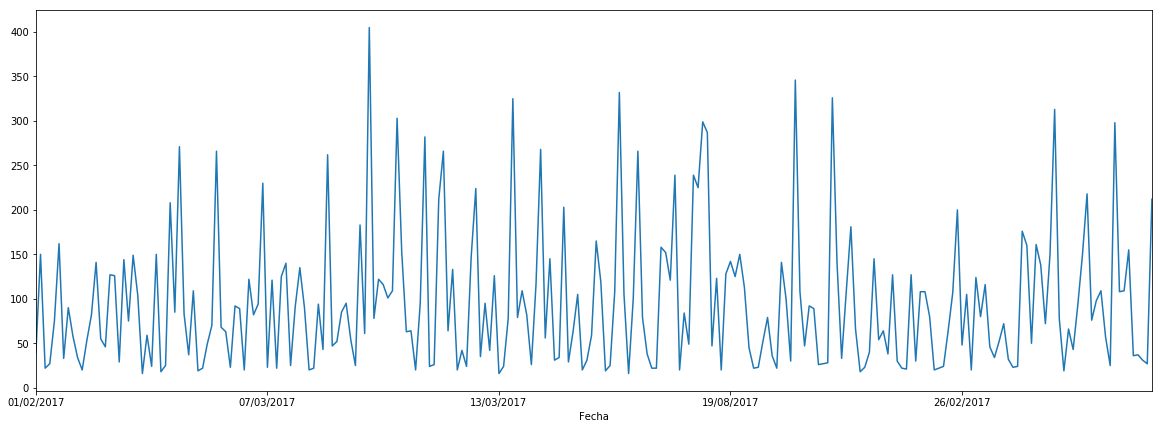

In [112]:
data.groupby('Fecha').Pedido.agg(np.sum).plot(figsize = (20, 7))

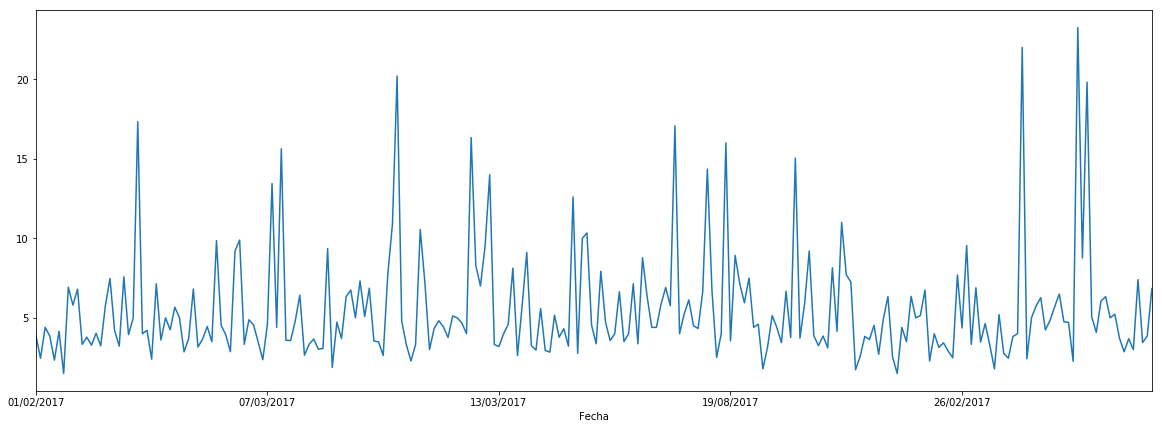

In [114]:
data.groupby('Fecha').Pedido.agg(np.mean).plot(figsize = (20, 7))

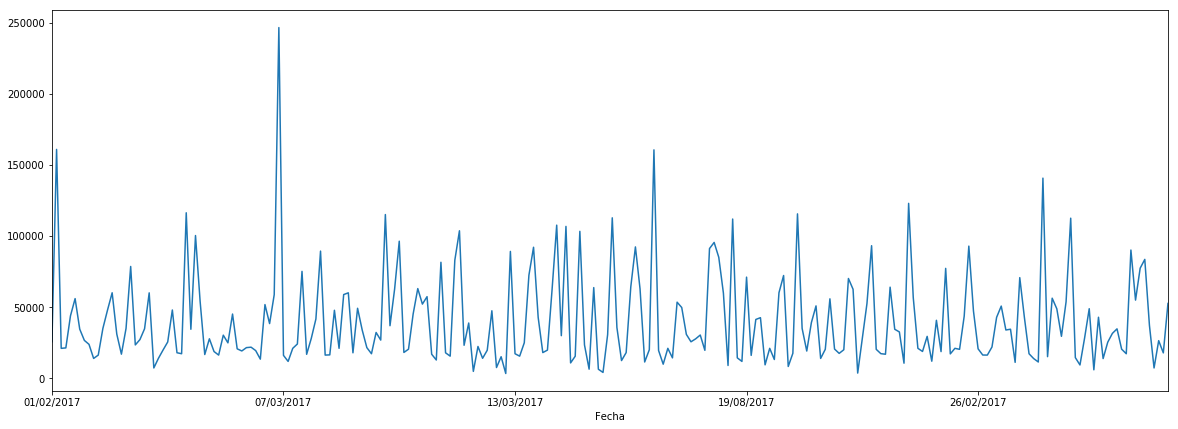

In [113]:
data.groupby('Fecha').Precio.agg(np.sum).plot(figsize = (20,7))

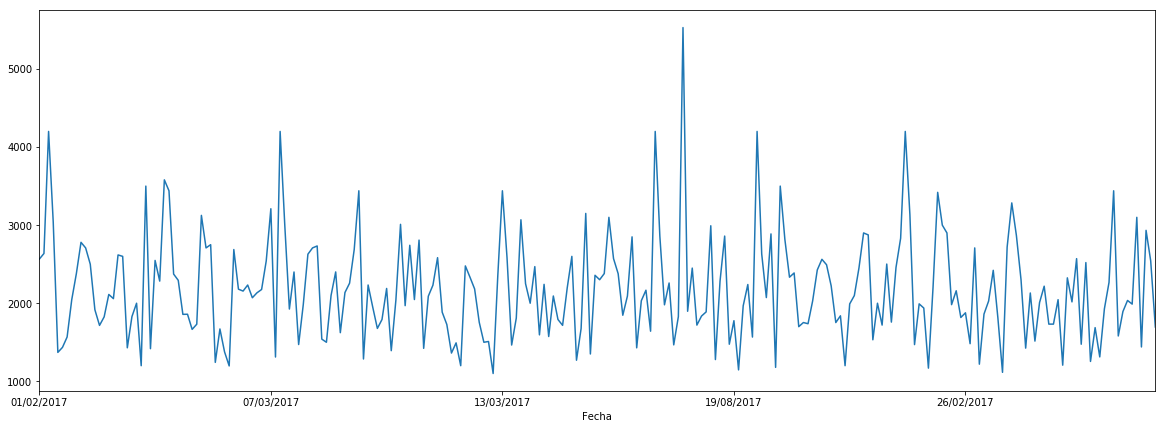

In [115]:
data.groupby('Fecha').Precio.agg(np.mean).plot(figsize = (20,7))

In [58]:
data.Fecha = pd.to_datetime(data.Fecha)

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4712 entries, 0 to 4711
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Cliente          4708 non-null   object        
 1   Fecha            4712 non-null   datetime64[ns]
 2   Pedido           4712 non-null   int64         
 3   Precio           4712 non-null   int64         
 4   Producto         4712 non-null   object        
 5   Nombre_producto  4712 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 221.0+ KB


In [39]:
data['week'] = data.Fecha.dt.isocalendar().week
data['weekday'] = data.Fecha.dt.weekday
data['dayofyear'] = data.Fecha.dt.dayofyear
data['day'] = data.Fecha.dt.day
data['month'] = data.Fecha.dt.month

In [40]:
data.head()

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto,week,weekday,dayofyear,day,month
0,Cliente26,2017-09-18,20,700,VER0049,Yerbabuena / 100 gramos,38,0,261,18,9
1,Cliente26,2017-09-18,10,1200,FRU0024,Limón Tahití / Libra,38,0,261,18,9
2,Cliente26,2017-09-18,4,1600,VER0041,Puerro / Libra,38,0,261,18,9
3,Cliente26,2017-09-18,10,1500,VER0038,Pimentón Rojo / Libra,38,0,261,18,9
4,Cliente26,2017-09-18,8,1100,VER0010,Zucchini Verde / Libra,38,0,261,18,9


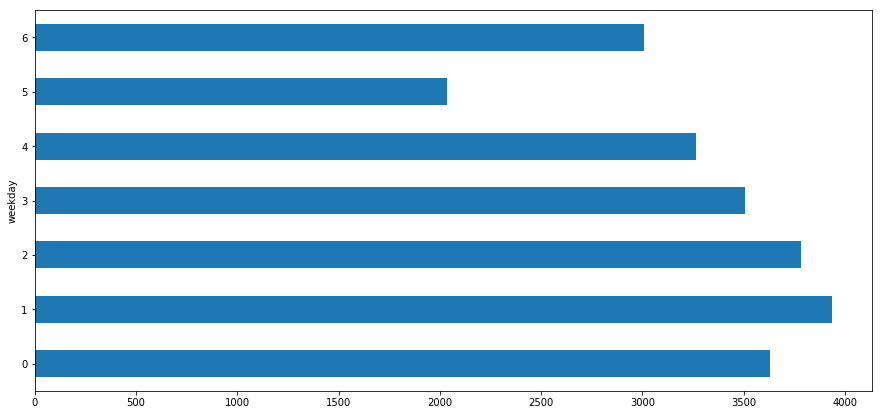

In [162]:
# ¿Que día de la semana se tienen más ingresos?
data.groupby('weekday')['Pedido'].agg(np.sum).plot(kind = 'barh', figsize = (15,7))

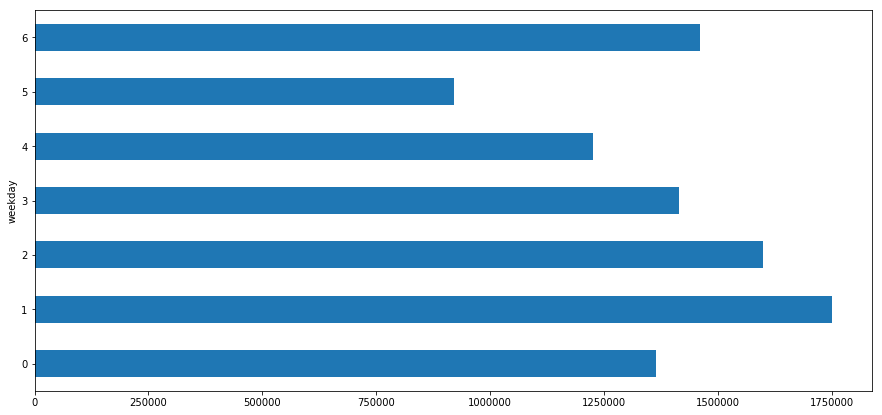

In [163]:
data.groupby('weekday')['Precio'].agg(np.sum).plot(kind = 'barh', figsize = (15,7))

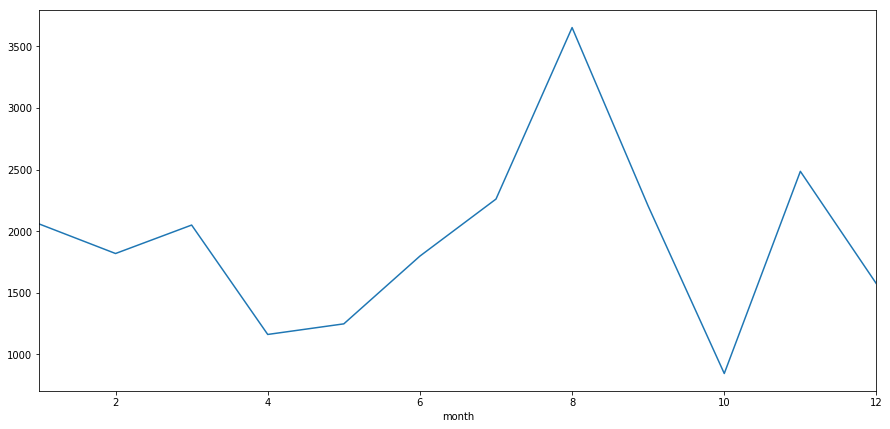

In [165]:
# ¿Que mes mes del año tienen más ingresos?
data.groupby('month')['Pedido'].agg(np.sum).plot(figsize = (15,7))

Antes de iniciar con estructurar la metodolgía, definiremos los valores perdidos de la serie de tiempo que tenemos. Usaremos la librería `missingno` para visualizar los valores perdidos.

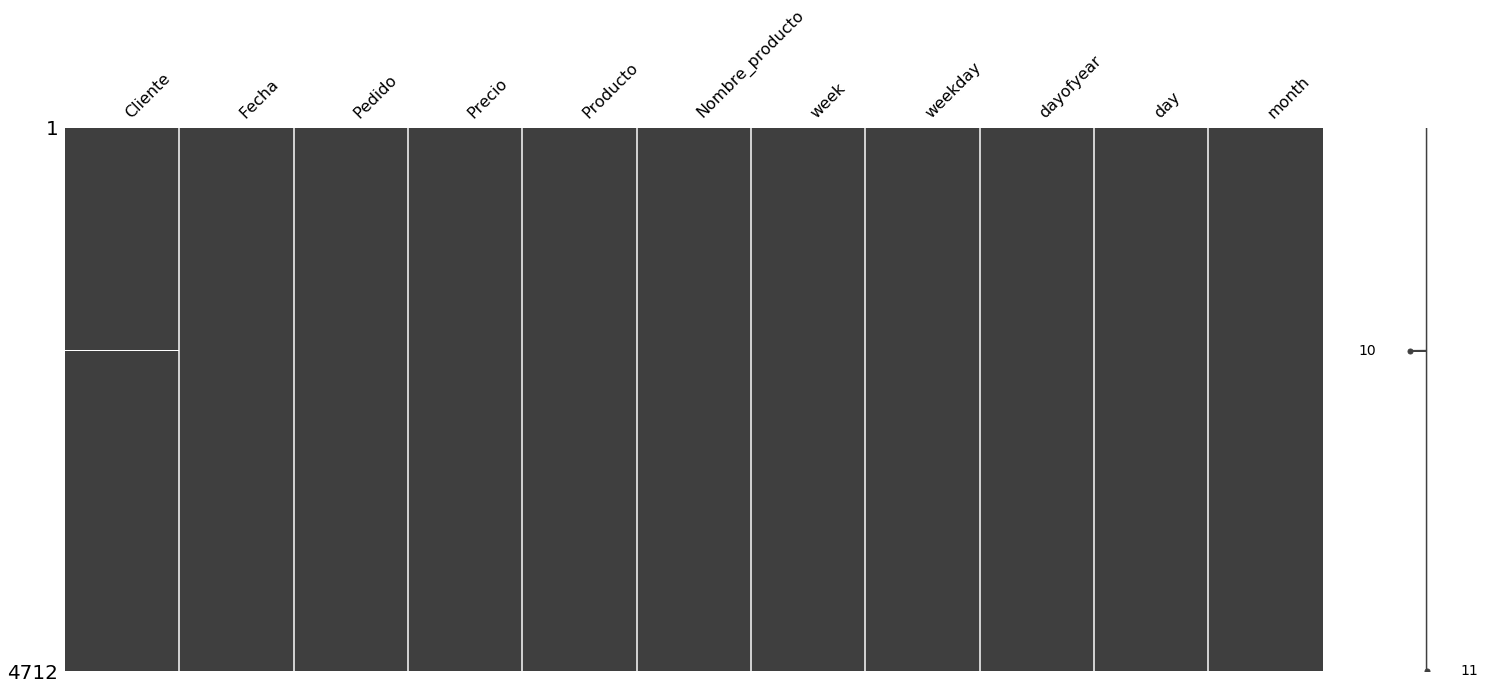

In [167]:
msno.matrix(data)

Parece ser que tenemos algunos valores perdidos en la variable de cliente. Revisemos contando todos los valores para tods las variables. A continuación:

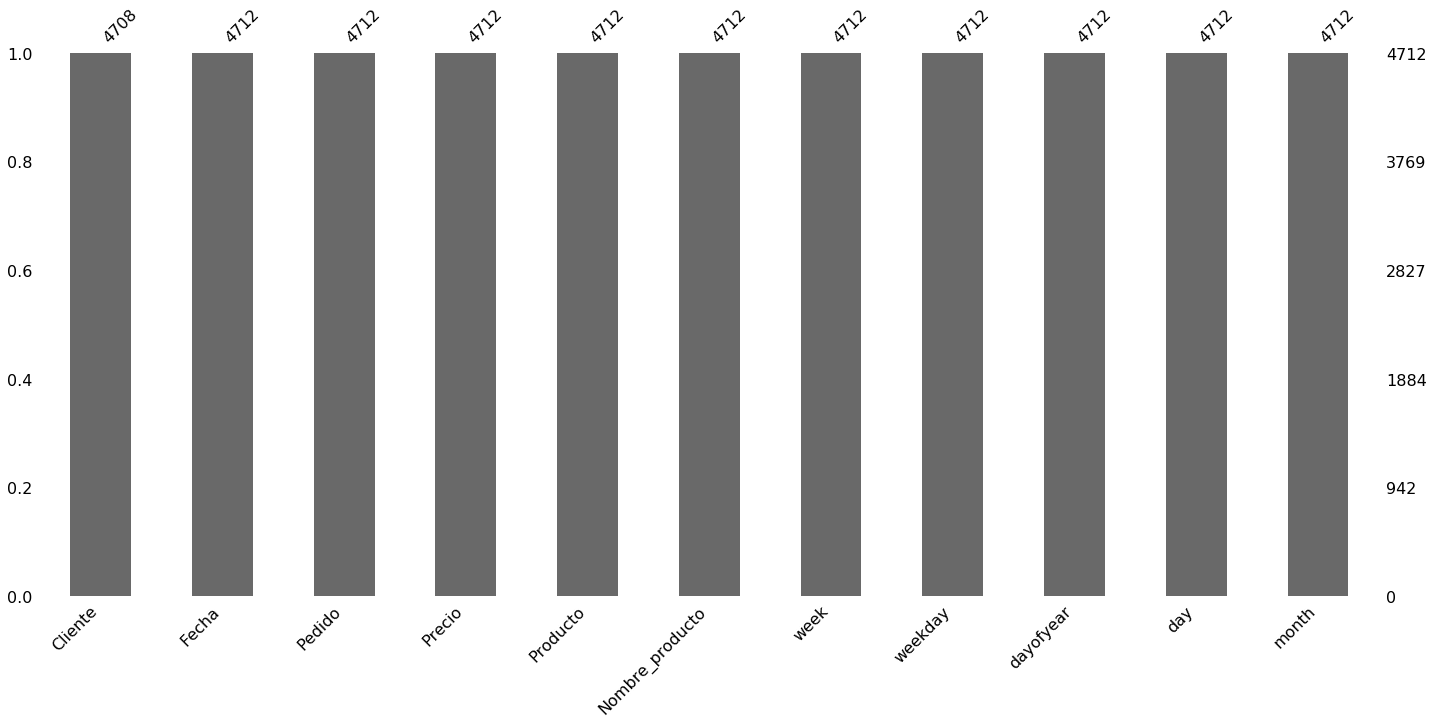

In [169]:
msno.bar(data)

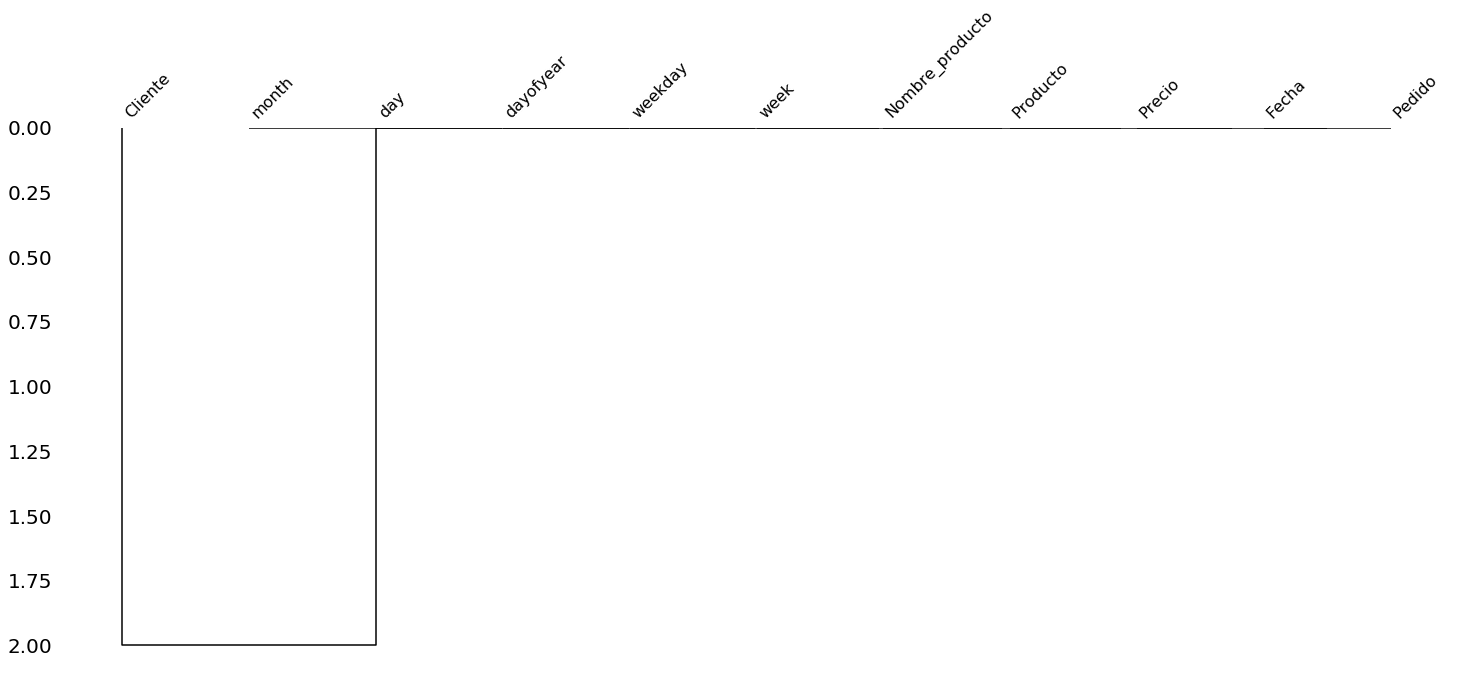

In [173]:
msno.dendrogram(data)

Como vemos, efectivamente tenemos valores perdidos para clientes. Evidenciandolo en el gráfico de barras y en el dendograma, tenemos dos valores perdidos en los clientes. 

¿Que pasa si hacemos un rango de fecha y lo intercalamos con los datos?

In [60]:
data[data.Fecha == min(data.Fecha)]

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
4343,Cliente7,2016-01-12,2,500,TUB0012,Zanahoria / Libra
4344,Cliente7,2016-01-12,3,1100,FRU0046,Tomate Chonto / Libra
4345,Cliente7,2016-01-12,1,1600,TUB0009,Rábano Rojo / Libra
4346,Cliente7,2016-01-12,1,1600,VER0041,Puerro / Libra
4347,Cliente7,2016-01-12,1,630,VER0035,Pepino Cohombro / Libra
4348,Cliente7,2016-01-12,1,2200,FRU0037,Papaya Melona / Unidad
4349,Cliente7,2016-01-12,2,1680,FRU0028,Mango Tommy Atkins / Libra
4350,Cliente7,2016-01-12,1,1200,VER0029,Lechuga Lisa / Unidad
4351,Cliente7,2016-01-12,2,750,VER0027,Lechuga Batavia / Unidad
4352,Cliente7,2016-01-12,1,520,TUB0004,Jengibre / 100 gramos


In [61]:
data[data.Fecha == max(data.Fecha)]

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
150,Cliente11,2017-12-09,6,1000,VER0052,Plátano Maduro / Libra
151,Cliente11,2017-12-09,10,3000,GRA0006,Mazorca Desgranada / Libra
152,Cliente11,2017-12-09,10,900,FRU0029,Manzana Roja / Unidad
153,Cliente11,2017-12-09,3,1500,FRU0016,Fresa Pareja / Libra
154,Cliente11,2017-12-09,6,1100,FRU0008,Banano Criollo / Libra


In [72]:
Fechas = pd.date_range(min(data.Fecha), max(data.Fecha), freq='D')
Fechas

DatetimeIndex(['2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15',
               '2016-01-16', '2016-01-17', '2016-01-18', '2016-01-19',
               '2016-01-20', '2016-01-21',
               ...
               '2017-11-30', '2017-12-01', '2017-12-02', '2017-12-03',
               '2017-12-04', '2017-12-05', '2017-12-06', '2017-12-07',
               '2017-12-08', '2017-12-09'],
              dtype='datetime64[ns]', length=698, freq='D')

In [77]:
data_dateindex = data.copy()

In [89]:
data_dateindex = data_dateindex.groupby('Fecha').agg(np.sum)
data_dateindex.head()

,Pedido,Precio
Fecha,,
2016-01-12,33,34480
2016-02-12,141,60060
2016-03-11,16,14000
2016-04-12,83,53910
2016-05-12,68,20650


In [82]:
#data_dateindex.index = pd.DatetimeIndex(data_dateindex.Fecha, yearfirst = True)
#data_dateindex.head()

In [91]:
data_dateindex = data_dateindex.reindex(Fechas, fill_value = None)
data_dateindex.head()

,Pedido,Precio
2016-01-12,33.0,34480.0
2016-01-13,NaN,NaN
2016-01-14,NaN,NaN
2016-01-15,NaN,NaN
2016-01-16,NaN,NaN


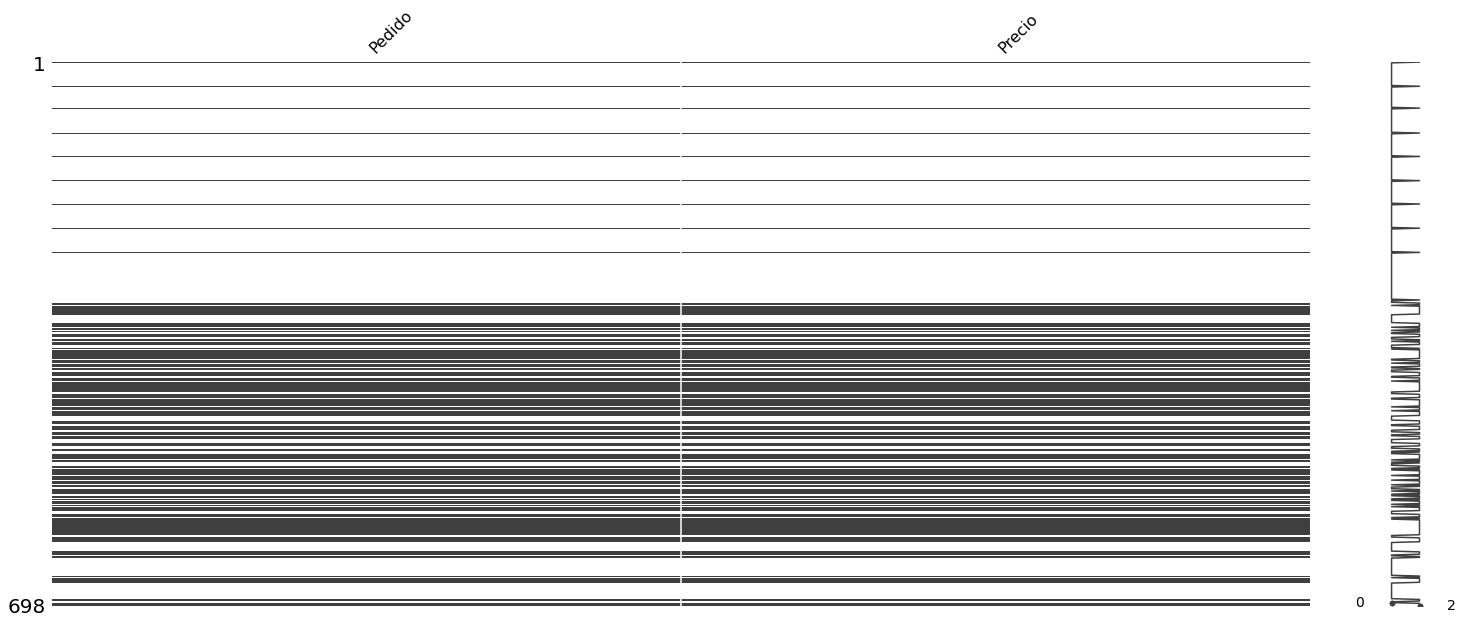

In [93]:
msno.matrix(data_dateindex)

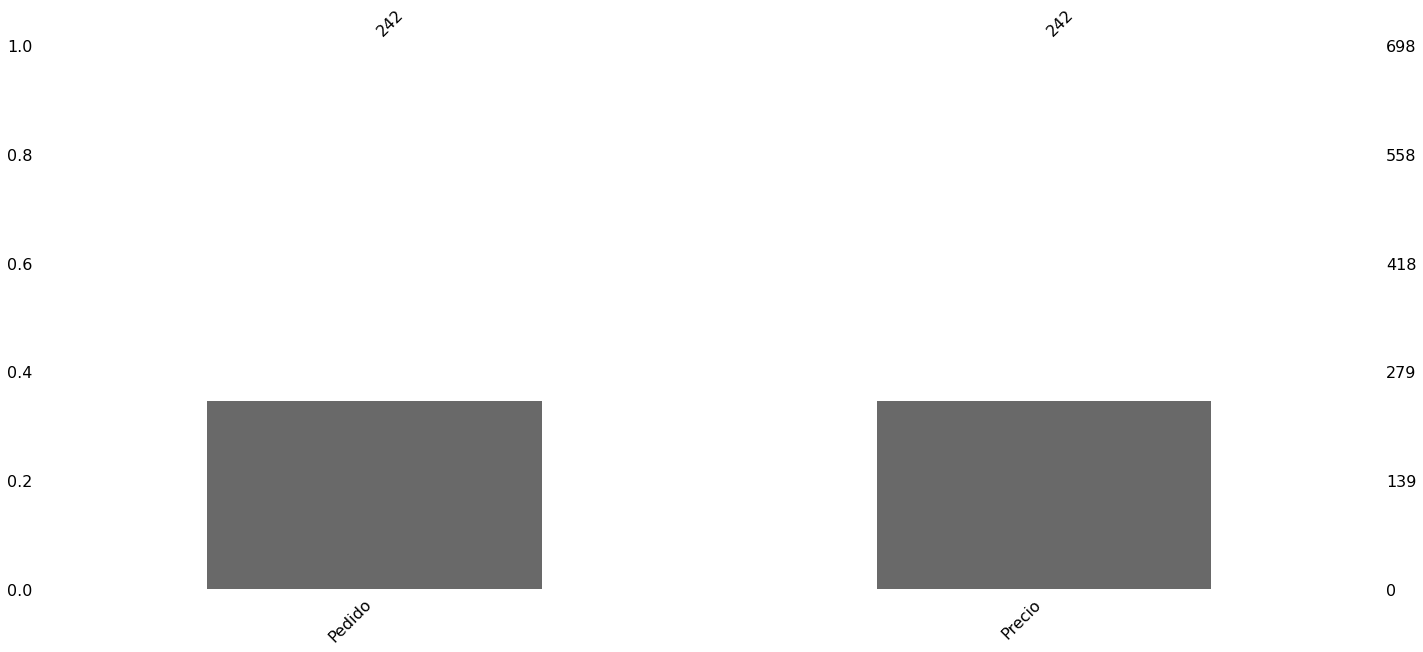

In [94]:
msno.bar(data_dateindex)

Como vemos, al colocar todos los datos de la Start-up contra un rango de fecha vemos que no tenemos un registro con todas las fechas en frecuencia diaría. Tenemos 242 fehas de las 698 que hay con frecuencia díaria dentro del rango de fechas, es decir, tenemos únicamente un 34% de información sobre el comportamiento de compra.

De forma que, podríamos asumir que no existen registro por que estos son valores nulos. Y también seguramente, podríamos llenarlos con 0. Quedando de esta manera:

In [100]:
data_dateindex = data.copy()

In [101]:
data_dateindex = data_dateindex.groupby('Fecha').agg(np.sum)
data_dateindex.head()

,Pedido,Precio
Fecha,,
2016-01-12,33,34480
2016-02-12,141,60060
2016-03-11,16,14000
2016-04-12,83,53910
2016-05-12,68,20650


In [103]:
data_dateindex = data_dateindex.reindex(Fechas, fill_value = 0)
data_dateindex.head()

,Pedido,Precio
2016-01-12,33,34480
2016-01-13,0,0
2016-01-14,0,0
2016-01-15,0,0
2016-01-16,0,0


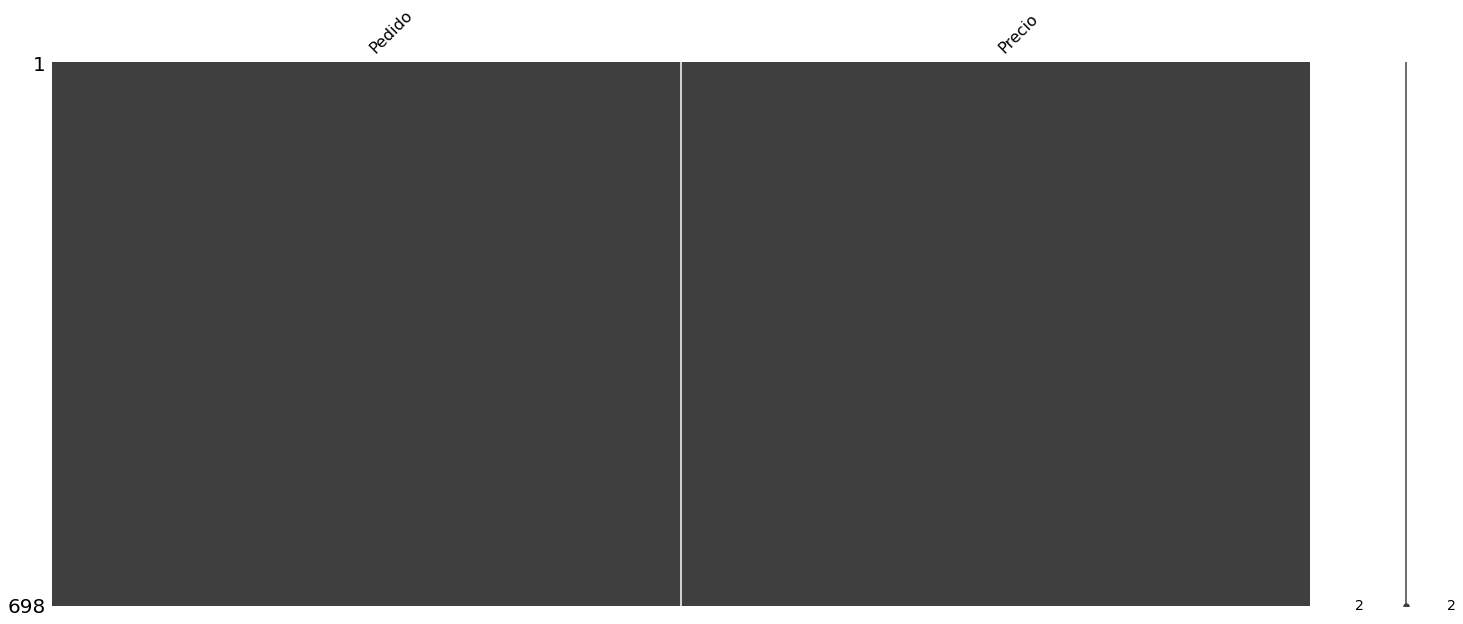

In [107]:
msno.matrix(data_dateindex)

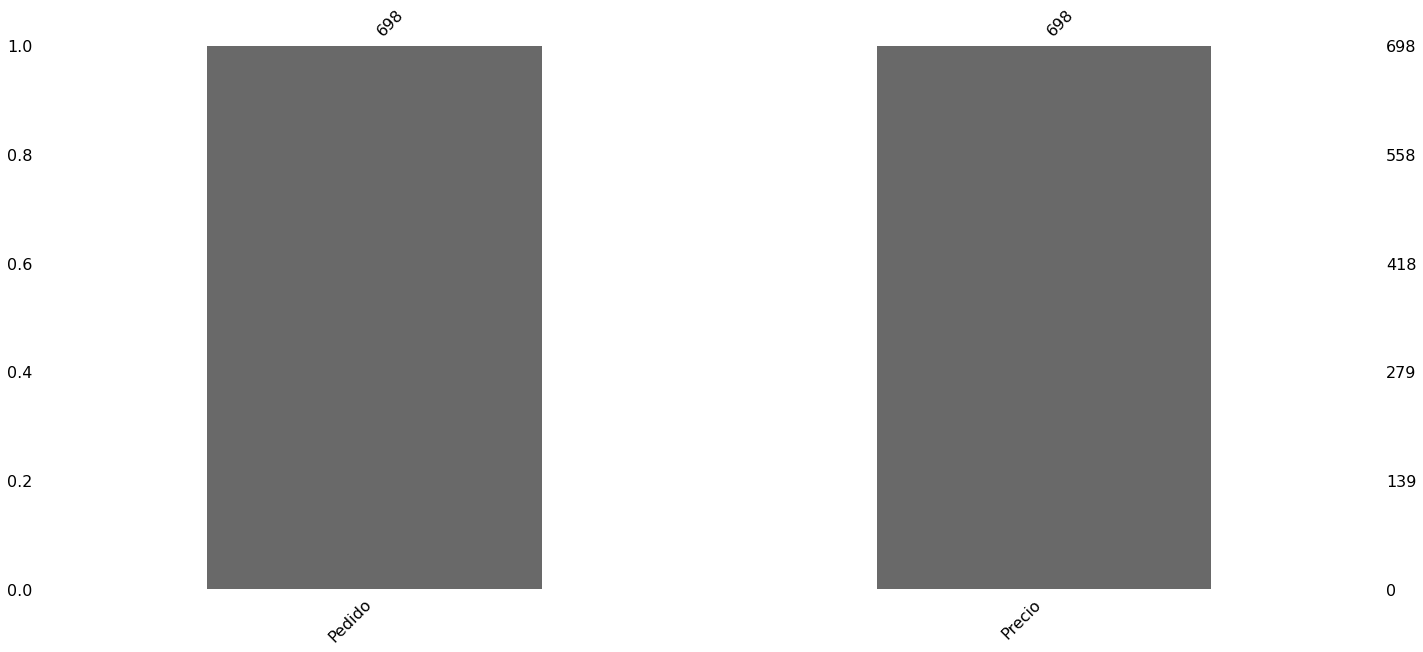

In [108]:
msno.bar(data_dateindex)

In [106]:
data_dateindex.head()

,Pedido,Precio
2016-01-12,33,34480
2016-01-13,0,0
2016-01-14,0,0
2016-01-15,0,0
2016-01-16,0,0


Ahora, definiremos un método para que nos realice este proceso para cada uno de los productos. De la siguiente manera:

In [188]:
Fechas_week = Fechas = pd.date_range(min(data.Fecha), max(data.Fecha), freq='W-Mon')
Fechas_week

DatetimeIndex(['2016-01-18', '2016-01-25', '2016-02-01', '2016-02-08',
               '2016-02-15', '2016-02-22', '2016-02-29', '2016-03-07',
               '2016-03-14', '2016-03-21', '2016-03-28', '2016-04-04',
               '2016-04-11', '2016-04-18', '2016-04-25', '2016-05-02',
               '2016-05-09', '2016-05-16', '2016-05-23', '2016-05-30',
               '2016-06-06', '2016-06-13', '2016-06-20', '2016-06-27',
               '2016-07-04', '2016-07-11', '2016-07-18', '2016-07-25',
               '2016-08-01', '2016-08-08', '2016-08-15', '2016-08-22',
               '2016-08-29', '2016-09-05', '2016-09-12', '2016-09-19',
               '2016-09-26', '2016-10-03', '2016-10-10', '2016-10-17',
               '2016-10-24', '2016-10-31', '2016-11-07', '2016-11-14',
               '2016-11-21', '2016-11-28', '2016-12-05', '2016-12-12',
               '2016-12-19', '2016-12-26', '2017-01-02', '2017-01-09',
               '2017-01-16', '2017-01-23', '2017-01-30', '2017-02-06',
      

In [189]:
def pedidos_producto(producto):
    data_dateindex = data.copy()
    data_dateindex = data_dateindex[data_dateindex.Producto == producto].resample('W-Mon', on='Fecha').sum().sort_values(by='Fecha')
    data_dateindex = data_dateindex.reindex(Fechas_week, fill_value = 0)
    return data_dateindex

In [190]:
pedidos_producto('VER0049')

,Pedido,Precio
2016-01-18,0,0
2016-01-25,0,0
2016-02-01,0,0
2016-02-08,0,0
2016-02-15,1,450
...,...,...
2017-11-06,10,700
2017-11-13,0,0
2017-11-20,0,0
2017-11-27,0,0


Revisemos los productos más pedidos. Estos serán para nosotros los productos con más de 1000 pedidos a la fecha que tenemos en los datos.

In [124]:
productos = pd.DataFrame(data["Pedido"].groupby(data["Producto"]).sum())
productos2 = productos[productos['Pedido']>1000]
productos3 = productos2.sort_values("Pedido", ascending= False)
productos3

,Pedido
Producto,
FRU0046,4000
VER0035,1360
VER0038,1324
VER0010,1211
VER0028,1094
VER0052,1064


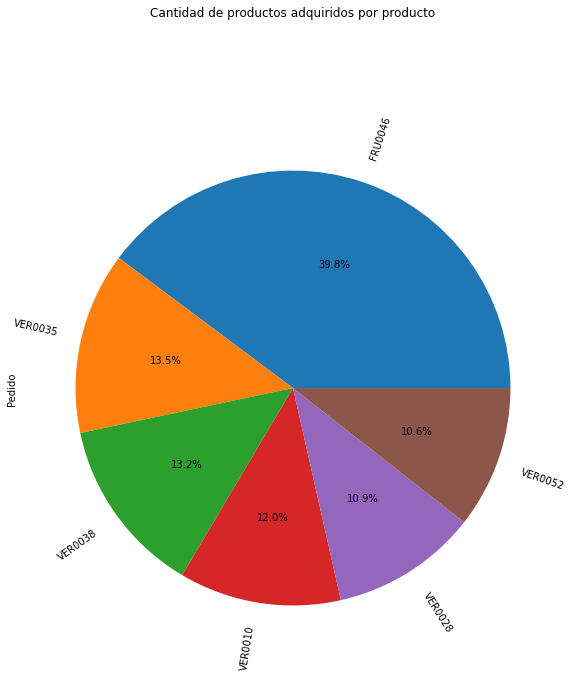

In [120]:
productos3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%', rotatelabels=True)
plt.title("Cantidad de productos adquiridos por producto", pad=100)
plt.show()

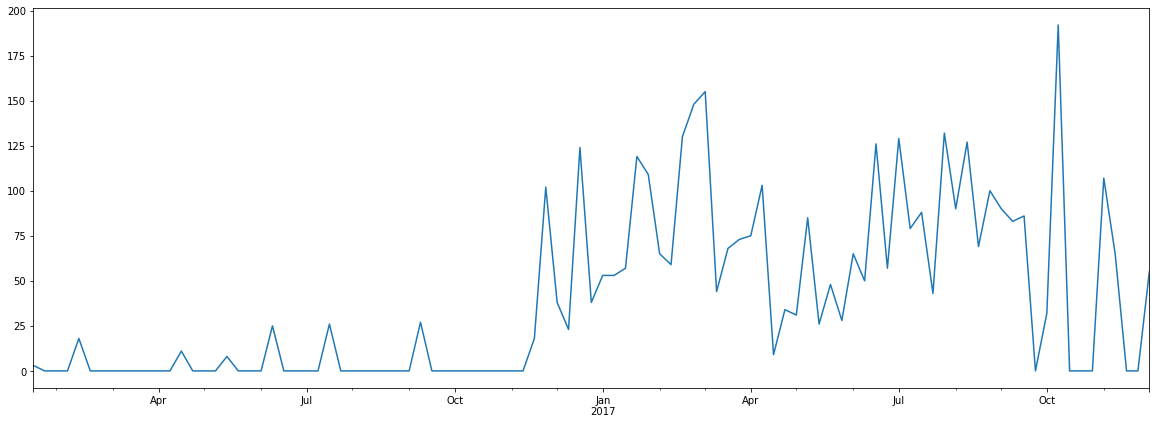

In [191]:
pedidos_producto('FRU0046').Pedido.plot(figsize = (20,7))

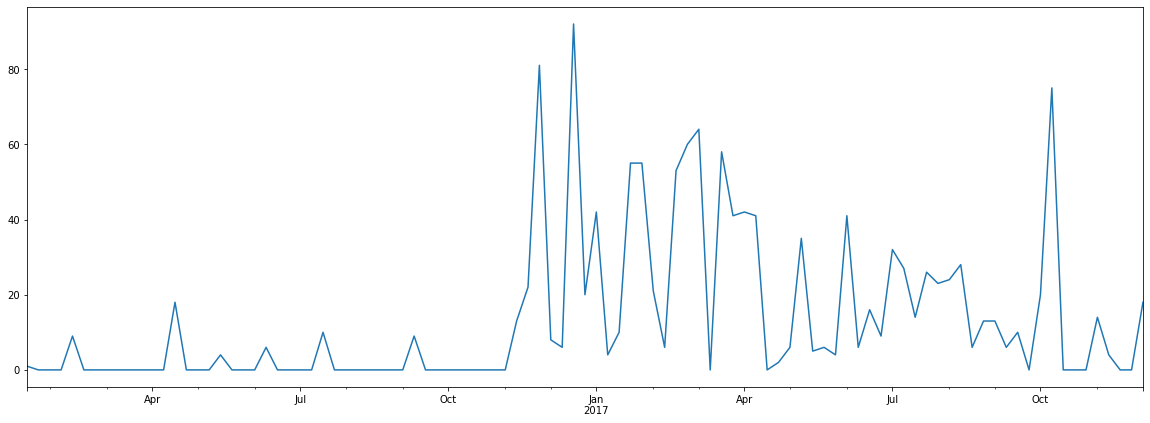

In [192]:
pedidos_producto('VER0035').Pedido.plot(figsize = (20,7))

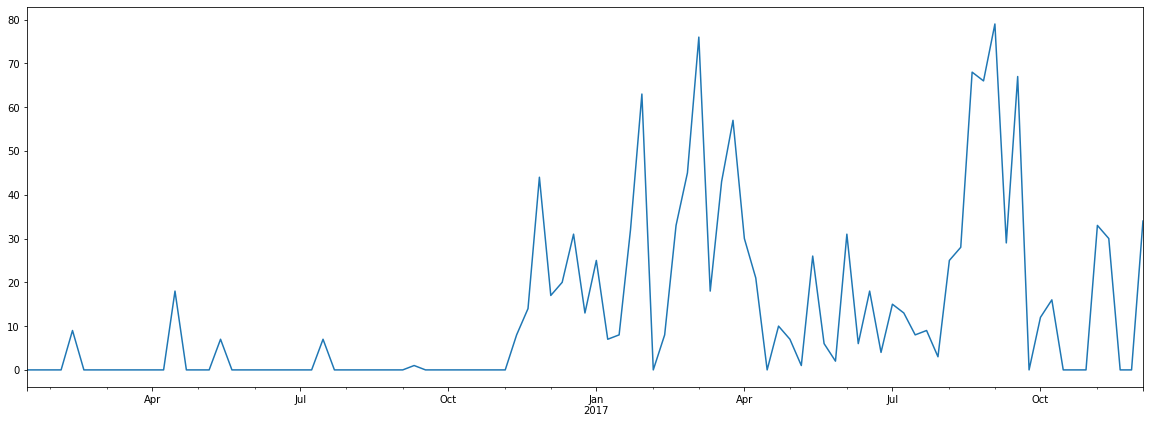

In [193]:
pedidos_producto('VER0038').Pedido.plot(figsize = (20,7))

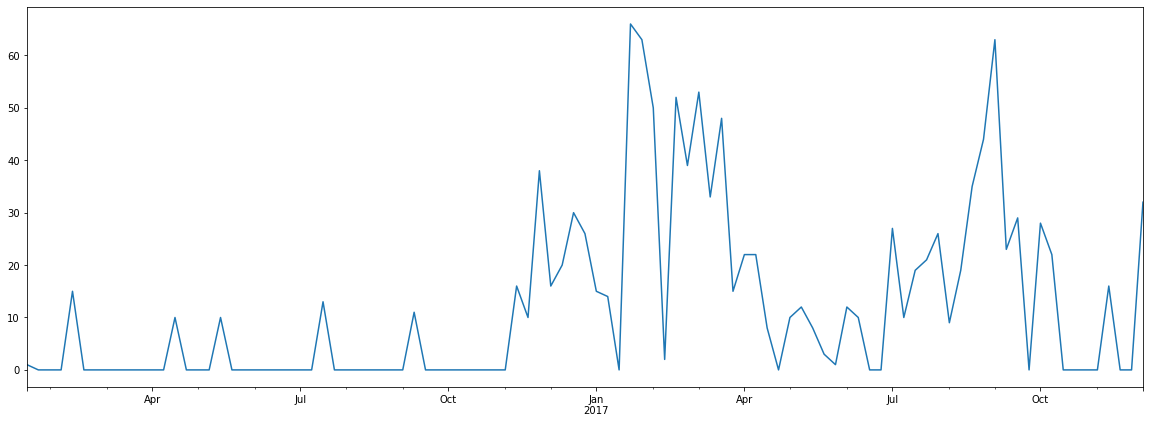

In [194]:
pedidos_producto('VER0010').Pedido.plot(figsize = (20,7))

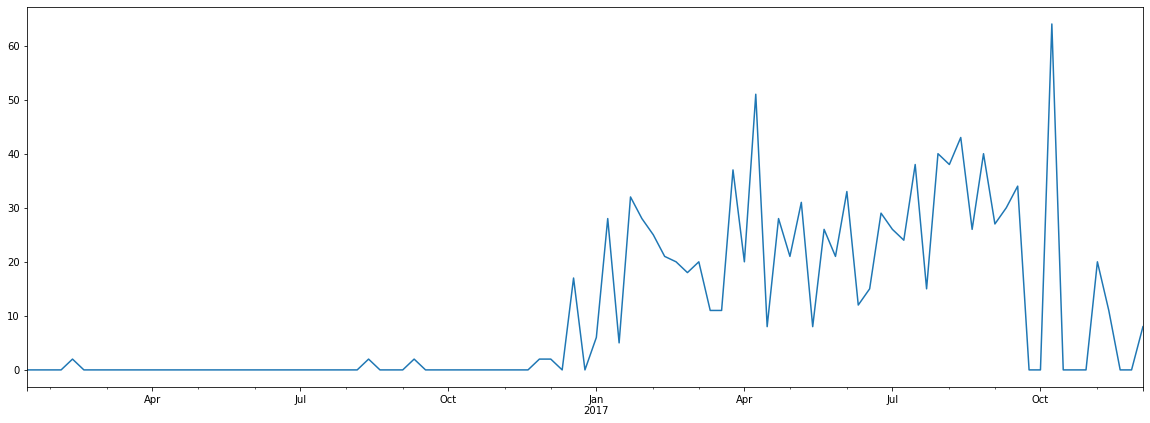

In [195]:
pedidos_producto('VER0028').Pedido.plot(figsize = (20,7))

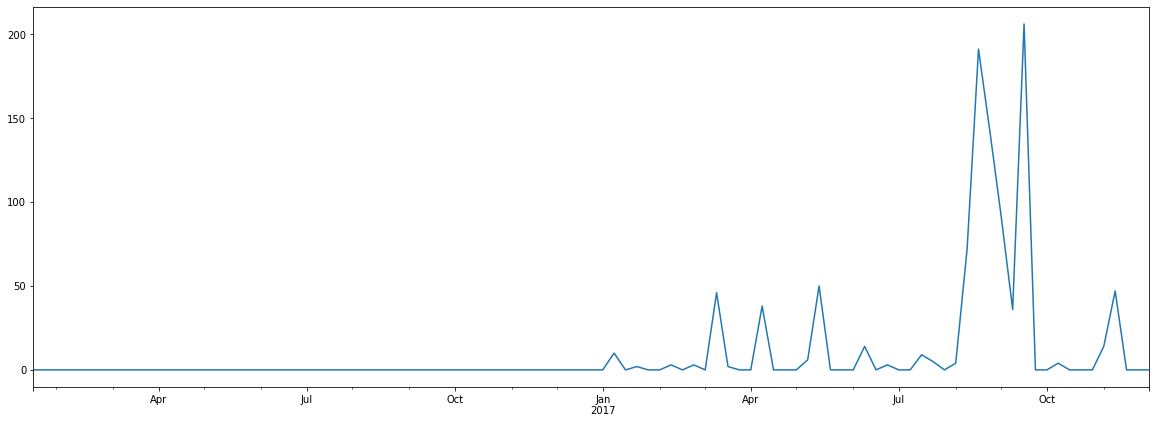

In [196]:
pedidos_producto('VER0052').Pedido.plot(figsize = (20,7))


---
**Metodología**

Nosotros usaremos un ajuste de pronóstico basado en Redes Neuronales Recurrentes testeado sobre un rolling forecast y con un ajuste en sus hiperparámetros automatizado con **Optuna**

De esta manera. Usaremos el siguiente conjunto de elementos en el siguiente orden:

* Para cada producto:
    1. RNN ajustadas con **Optuna**
    2. Rolling forecast la serie de tiempo

La metríca de evaluación es el RMSE. Y usaremos un RMSE ponderado por la demanda de cada producto. Es decir, esa ponderación dará un peso: $0 < peso_i < 1 \forall i \in I$ donde, $I: \text{conjunto de productos seleccionado}$.

Con esto, seleccionaremos un número $n$ de productos para usarlos en el conjunto $I$. ¿Como seleccionar los producto? Estos serán seleccionados en dos momentos. El primer momento, se seleccionarán los 5 productos que más demanda tienen. Luego de testear el algoritmo, usaremos este mismo con los productos que seleccionaremos en el segundo momento. El segundo momento tendrá todos los elementos que tengan una demanda de pedidos mayor a 140.

Antes de usar **Optuna** realizaremos una implementación sencilla. Con un modelo de redes neuronales recurrentes y celdas GRU. Podríamos usar un loop que recorra: `data.Producto.unique(): ` De la siguiente manera:

## Corriendo el producto: VER0049

Producto número: 1 , Total de productos: 121 , avance: 1.0%


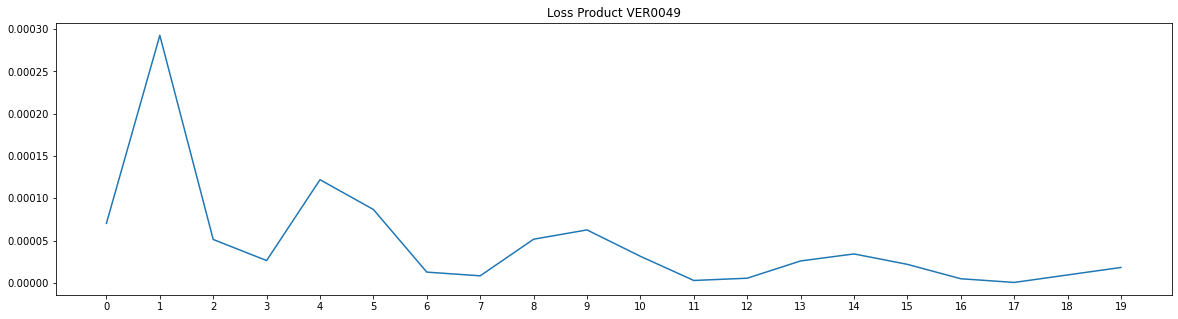

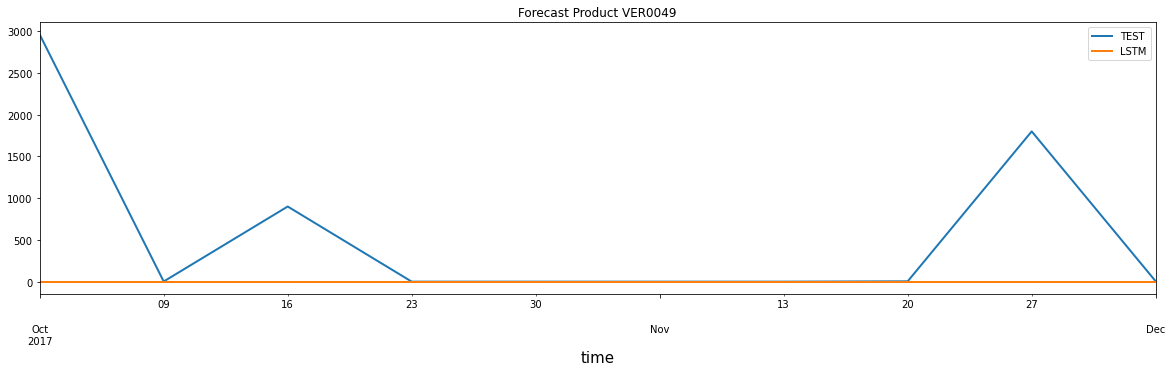

    SI rolling forecast -> Test RMSE: 1131.8849764883357
    NO rolling forecast -> Test RMSE: 1281163.6


In [197]:
Producto_no = 0
for Producto in data.Producto.unique(): 
    Producto_no += 1
    display(Markdown("## Corriendo el producto: " + Producto))
    print(f'Producto número: {Producto_no} , Total de productos: {len(data.Producto.unique())} , avance: {round(Producto_no/len(data.Producto.unique()), 2)*100}%')
    # Filtrando por producto
    temp = pedidos_producto(Producto)
    
    # Creando train y test
    size = int(len(temp)*0.9)
    train_Y, test_Y = temp.values.reshape(-1, 1)[0:size], temp.values.reshape(-1, 1)[size:len(temp)]
    #print(train_Y, test_Y)

    # Realizando transformación MaxMinScaler
    scaler = MinMaxScaler()
    scaler.fit(train_Y, y=None)
    scaled_train_data = scaler.transform(train_Y)
    scaled_test_data = scaler.transform(test_Y)

    # Construyendo el generador
    n_input = train_Y.shape[0]; n_features= 1
    generator = timeseries_dataset_from_array(scaled_train_data, scaled_train_data, sequence_length=n_input, sampling_rate = n_features, batch_size=1, shuffle=False)

    # Creando modelo
    lstm_model = Sequential()
    lstm_model.add(LSTM(200, input_shape=(n_input, n_features)))
    #lstm_model.add(LSTM(units=50, return_sequences = True))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    #lstm_model.summary()

    # Entrenando modelo
    lstm_model.fit(generator, epochs=20, verbose = 0)

    # Viendo perdida en el modelo
    losses_lstm = lstm_model.history.history['loss']
    plt.figure(figsize=(20,5))
    plt.xticks(np.arange(0,21,1))
    plt.title(f'Loss Product {Producto}')
    plt.plot(range(len(losses_lstm)),losses_lstm)
    plt.show(); 

    # realizando roling forecast
    lstm_predictions_scaled = list()
    batch = scaled_train_data[-n_input:]
    current_batch = batch.reshape((1, n_input, n_features))

    for i in range(len(test_Y)):
        lstm_pred = K.round(lstm_model.predict(current_batch)[0])
        lstm_predictions_scaled.append(lstm_pred)
        current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

    # Transformando del scaler
    lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
    rolling_error_LSTM = mean_squared_error(test_Y, lstm_predictions) ** 0.5

    # Grafincando el rollback
    RollBack=pd.concat([pd.DataFrame({'TEST':np.concatenate(test_Y)}), pd.DataFrame({'LSTM':np.concatenate(lstm_predictions, axis=0)})], axis=1)
    # agregando fechas al rollback
    RollBack = pd.concat([RollBack,pd.DataFrame({'Time':temp.index[size:]})],axis=1)

    # Colocando en index
    RollBack.set_index('Time', inplace=True)
    RollBack.head()
    RollBack.plot(figsize=(20,5), linewidth=2, fontsize=10)
    plt.title(f'Forecast Product {Producto}')
    plt.xlabel('time', fontsize=15)
    plt.show(); 

    # Agregando valores al Error de todos los productos
    error_LSTM = mean_squared_error(RollBack.TEST, RollBack.LSTM)
    print(f'    SI rolling forecast -> Test RMSE: {rolling_error_LSTM}')
    print(f'    NO rolling forecast -> Test RMSE: {error_LSTM}')
    break

Pero únicamente, lo usaremos para los productos con pedidos mayores a 1000. De la siguiente manera:

In [157]:
Productos = ['FRU0046', 'VER0035', 'VER0038', 'VER0010', 'VER0028', 'VER0052']

## Corriendo el producto: FRU0046

Producto número: 1 , Total de productos: 6 , avance: 17.0%


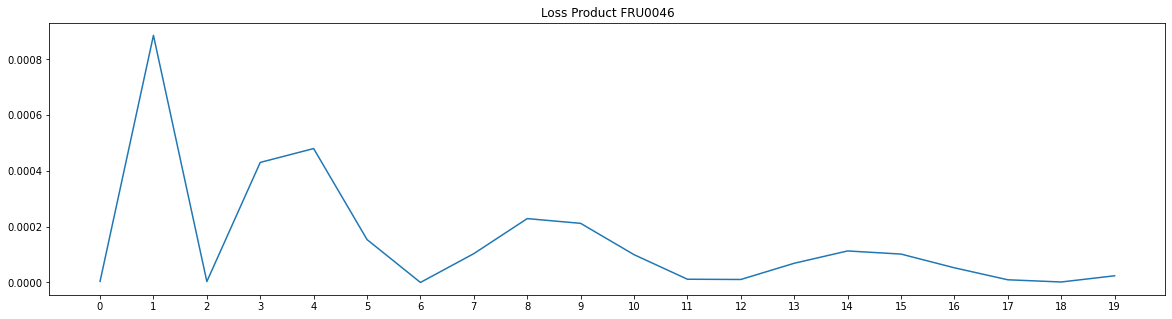

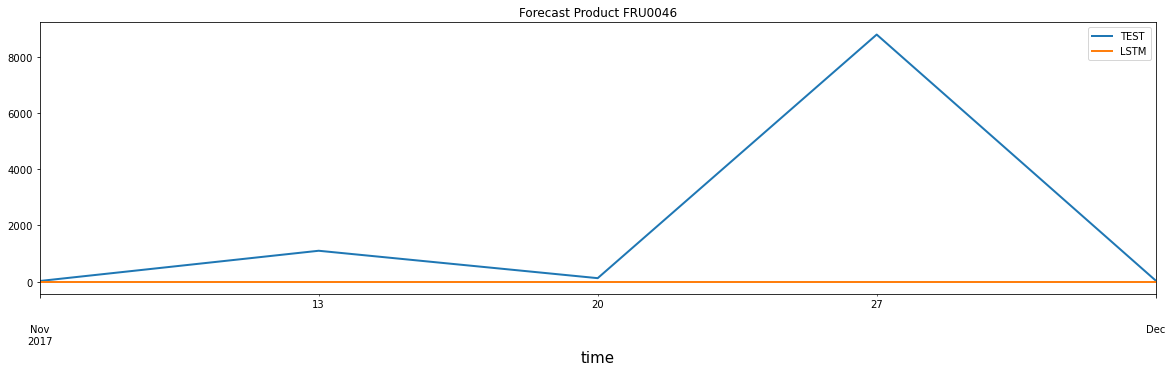

    SI rolling forecast -> Test RMSE: 3966.543810422368
    NO rolling forecast -> Test RMSE: 15733469.8


## Corriendo el producto: VER0035

Producto número: 2 , Total de productos: 6 , avance: 33.0%


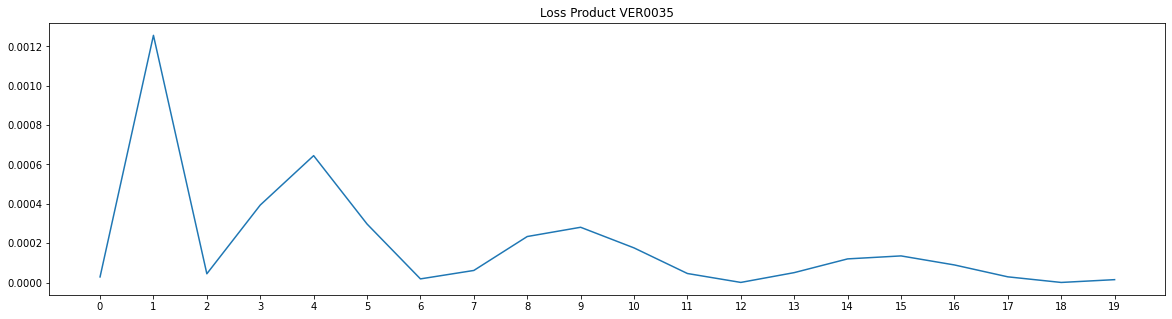

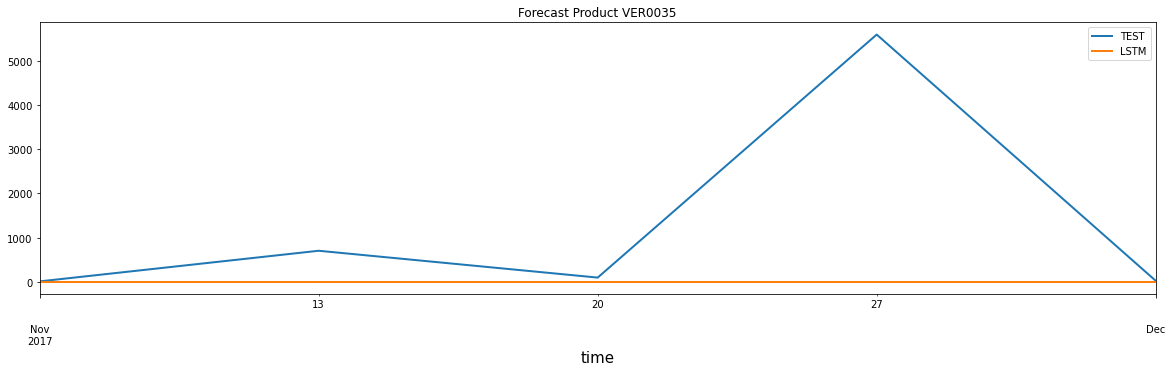

    SI rolling forecast -> Test RMSE: 2524.238499032926
    NO rolling forecast -> Test RMSE: 6371780.0


## Corriendo el producto: VER0038

Producto número: 3 , Total de productos: 6 , avance: 50.0%


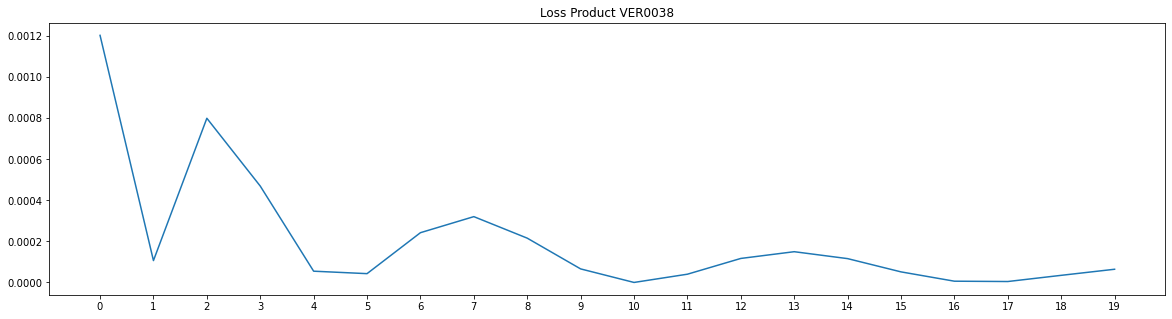

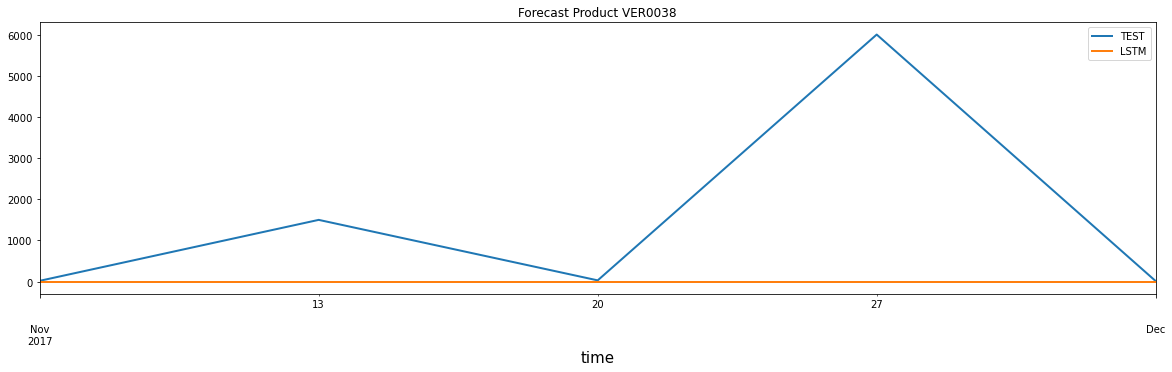

    SI rolling forecast -> Test RMSE: 2765.918653901448
    NO rolling forecast -> Test RMSE: 7650306.0


## Corriendo el producto: VER0010

Producto número: 4 , Total de productos: 6 , avance: 67.0%


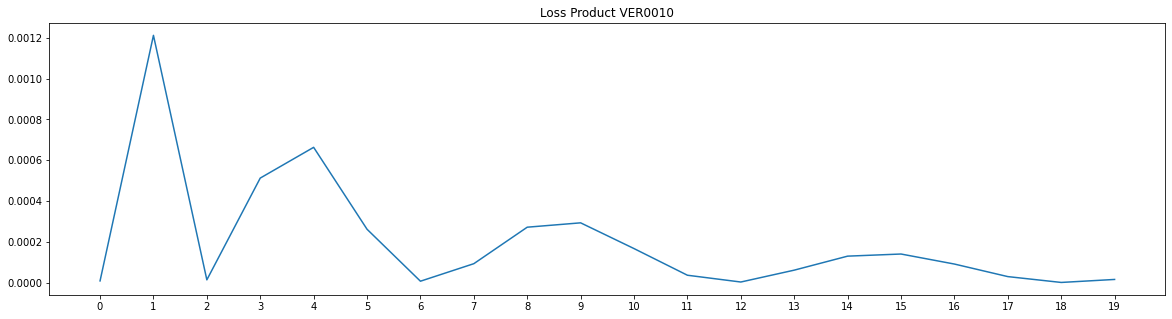

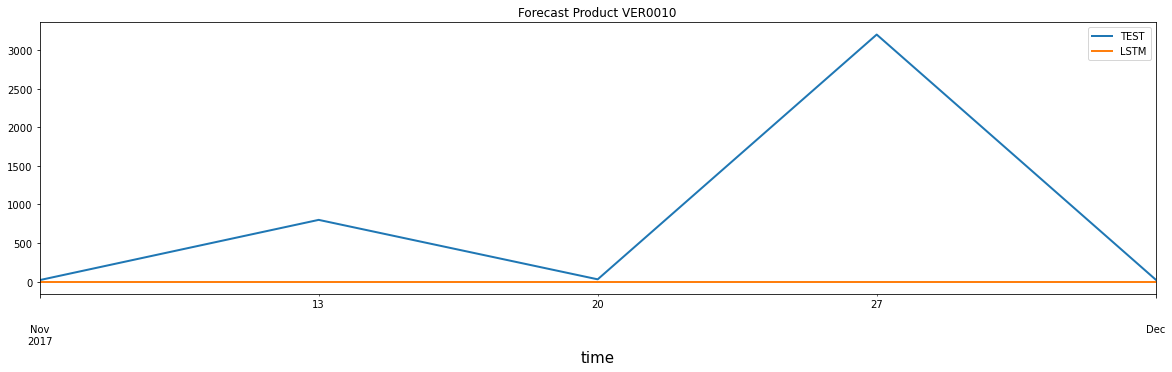

    SI rolling forecast -> Test RMSE: 1475.2610616429895
    NO rolling forecast -> Test RMSE: 2176395.2


## Corriendo el producto: VER0028

Producto número: 5 , Total de productos: 6 , avance: 83.0%


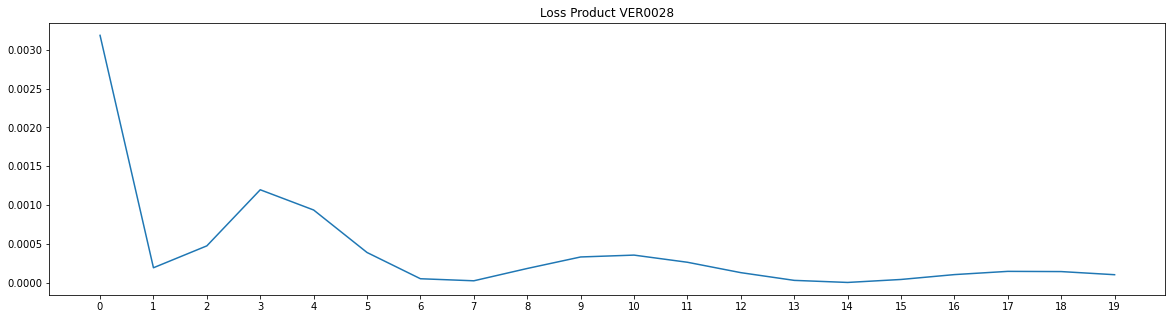

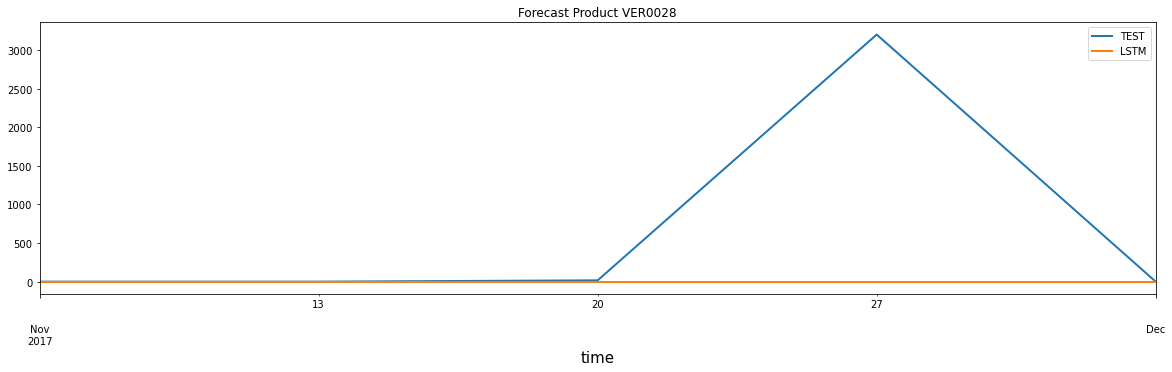

    SI rolling forecast -> Test RMSE: 1431.1036999463038
    NO rolling forecast -> Test RMSE: 2048057.8


## Corriendo el producto: VER0052

Producto número: 6 , Total de productos: 6 , avance: 100.0%


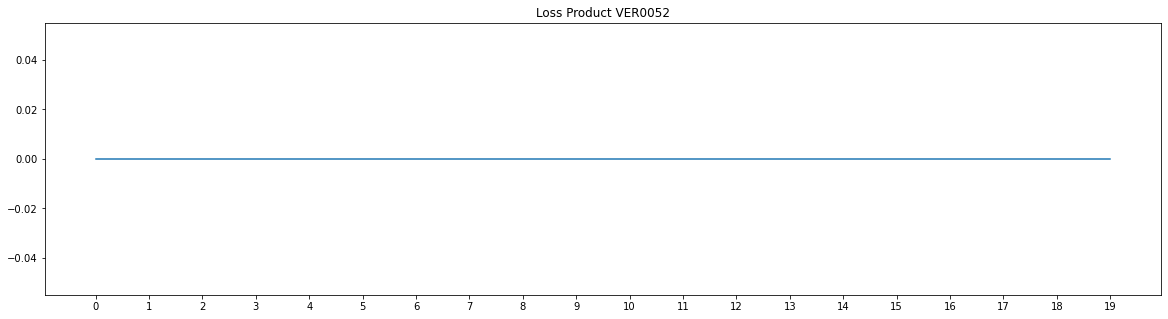

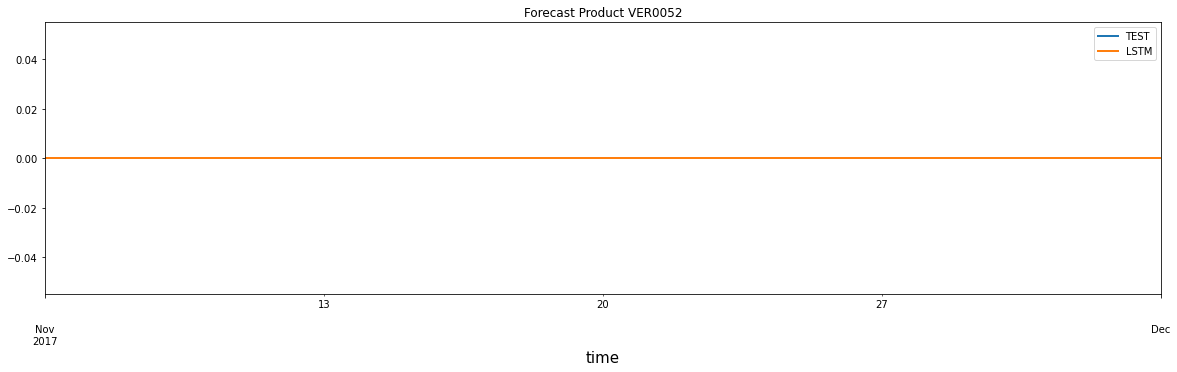

    SI rolling forecast -> Test RMSE: 0.0
    NO rolling forecast -> Test RMSE: 0.0


In [199]:
Producto_no = 0
for Producto in Productos: 
    Producto_no += 1
    display(Markdown("## Corriendo el producto: " + Producto))
    print(f'Producto número: {Producto_no} , Total de productos: {len(Productos)} , avance: {round(Producto_no/len(Productos), 2)*100}%')
    # Filtrando por producto
    temp = pedidos_producto(Producto)
    
    # Creando train y test
    size = int(len(temp)*0.95)
    train_Y, test_Y = temp.values.reshape(-1, 1)[0:size], temp.values.reshape(-1, 1)[size:len(temp)]
    #print(train_Y, test_Y)

    # Realizando transformación MaxMinScaler
    scaler = MinMaxScaler()
    scaler.fit(train_Y, y=None)
    scaled_train_data = scaler.transform(train_Y)
    scaled_test_data = scaler.transform(test_Y)

    # Construyendo el generador
    n_input = train_Y.shape[0]; n_features= 1
    generator = timeseries_dataset_from_array(scaled_train_data, scaled_train_data, sequence_length=n_input, sampling_rate = n_features, batch_size=1, shuffle=False)

    # Creando modelo
    lstm_model = Sequential()
    lstm_model.add(LSTM(200, input_shape=(n_input, n_features)))
    #lstm_model.add(LSTM(units=50, return_sequences = True))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    #lstm_model.summary()

    # Entrenando modelo
    lstm_model.fit(generator, epochs=20, verbose = 0)

    # Viendo perdida en el modelo
    losses_lstm = lstm_model.history.history['loss']
    plt.figure(figsize=(20,5))
    plt.xticks(np.arange(0,21,1))
    plt.title(f'Loss Product {Producto}')
    plt.plot(range(len(losses_lstm)),losses_lstm)
    plt.show(); 

    # realizando roling forecast
    lstm_predictions_scaled = list()
    batch = scaled_train_data[-n_input:]
    current_batch = batch.reshape((1, n_input, n_features))

    for i in range(len(test_Y)):
        lstm_pred = K.round(lstm_model.predict(current_batch)[0])
        lstm_predictions_scaled.append(lstm_pred)
        current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

    # Transformando del scaler
    lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
    rolling_error_LSTM = mean_squared_error(test_Y, lstm_predictions) ** 0.5

    # Grafincando el rollback
    RollBack=pd.concat([pd.DataFrame({'TEST':np.concatenate(test_Y)}), pd.DataFrame({'LSTM':np.concatenate(lstm_predictions, axis=0)})], axis=1)
    # agregando fechas al rollback
    RollBack = pd.concat([RollBack,pd.DataFrame({'Time':temp.index[size:]})],axis=1)

    # Colocando en index
    RollBack.set_index('Time', inplace=True)
    RollBack.head()
    RollBack.plot(figsize=(20,5), linewidth=2, fontsize=10)
    plt.title(f'Forecast Product {Producto}')
    plt.xlabel('time', fontsize=15)
    plt.show(); 

    # Agregando valores al Error de todos los productos
    error_LSTM = mean_squared_error(RollBack.TEST, RollBack.LSTM)
    print(f'    SI rolling forecast -> Test RMSE: {rolling_error_LSTM}')
    print(f'    NO rolling forecast -> Test RMSE: {error_LSTM}')

    #break

Como vemos, el pronóstico es muy poco directo. De manera que, usaremos **Optuna** para mejorarlo (si es posible).

In [205]:
initnorm = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=1)

In [207]:
def create_model(trial):
    """
    create_model create RNN with some LSTM layers.

    :param trial: Search space to optim with optuna
    :type trial: optuna.trial object
    :return: RNN model
    :rtype: tensorflow model
    """
    keras.backend.clear_session()
    model = Sequential()
    n_layers = trial.suggest_int('n_layers', 1, 5)
    for i in range(n_layers):
        num_hidden_one = trial.suggest_int(f"layer_Bidirectional_{i}_n_units", 4, 128, log=True)
        model.add(layers.Bidirectional(layers.LSTM(num_hidden_one, return_sequences=True)))
    num_hidden_two = trial.suggest_int("layer_Bidirectional_n_units", 4, 128, log=True)
    model.add(layers.Bidirectional(layers.LSTM(num_hidden_two)))
    for k in range(n_layers):
        num_hidden = trial.suggest_int(f'layer_Dense_{k}_n_units', 4, 128, log=True)
        activation_selected = trial.suggest_categorical(f"layer_Dense_{k}_activation", ["selu", "sigmoid", "tanh"])
        model.add(layers.Dense(num_hidden, activation=activation_selected, kernel_initializer=initnorm, bias_initializer='zeros'))
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [206]:
def create_optimizer(trial):
    """
    create_optimizer build and choose an optimazer

    :param trial: Search space to optim with optuna
    :type trial: optuna.trial object
    :return: optimizador de tensorflow
    :rtype: tf.optimizers
    """
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
        kwargs["beta_1"] = trial.suggest_loguniform('beta_1', 0.0001, 0.9)
        kwargs["beta_2"] = trial.suggest_loguniform('beta_2', 0.0001, 0.9)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

In [243]:
def trainer(trial):

    # Inicializamos la tabla donde guardamos los resultados
    x = PrettyTable(["Exac_E", "Exac_V", "Exac_P", "Optimizer"])
    temp = pickle.load(open(os.path.join('../temp/temp.dat'), 'rb'))
    Producto = pickle.load(open(os.path.join('../temp/Producto.dat'), 'rb'))
    Error = pickle.load(open(os.path.join('../temp/Error.dat'), 'rb'))

    # Inicializamos el error
    err_p = 999

    for i in range(0,3,1):
        r = i^3
        size = int(len(temp)*0.95)
        train_Y, test_Y = temp.values.reshape(-1, 1)[0:size], temp.values.reshape(-1, 1)[size:len(temp)]
        epocas = trial.suggest_categorical('epocas', [20, 40])

        scaler = MinMaxScaler()
        scaler.fit(train_Y, y=None)
        scaled_train_data = scaler.transform(train_Y)
        scaled_test_data = scaler.transform(test_Y)
        n_input = train_Y.shape[0]; n_features= 1
        generator = timeseries_dataset_from_array(scaled_train_data,
                                                scaled_train_data,
                                                sequence_length=n_input,
                                                sampling_rate = n_features,
                                                batch_size=1, shuffle=False)


        model = create_model(trial)
        optimizer = create_optimizer(trial)
        model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

        # Ajustamos el modelo
        history = model.fit(generator, epochs=epocas, verbose=0, shuffle=False)

        # Rolling forecast
        lstm_predictions_scaled = list()
        batch = scaled_train_data[-n_input:]
        current_batch = batch.reshape((1, n_input, n_features))
        for i in range(len(test_Y)):
            lstm_pred = K.round(model.predict(current_batch)[0])
            lstm_predictions_scaled.append(lstm_pred)
            current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)
        lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

        # Gráfica de perdida
        losses_lstm = history.history['loss']
        plt.figure(figsize=(20,5))
        plt.xticks(np.arange(0,21,1))
        plt.title(f'Loss Product {Producto}')
        plt.plot(range(len(losses_lstm)),losses_lstm)
        plt.show();

        # Gráfica de validación
        RollBack=pd.concat([pd.DataFrame({'TEST':np.concatenate(test_Y)}), pd.DataFrame({'LSTM':np.concatenate(lstm_predictions, axis=0)})], axis=1)
        RollBack = pd.concat([RollBack,pd.DataFrame({'Time':temp.index[size:]})],axis=1)
        RollBack.set_index('Time', inplace=True)
        RollBack.plot(figsize=(20,5), linewidth=2, fontsize=10)
        plt.title(f'Forecast Product {Producto}')
        plt.xlabel('time', fontsize=15)
        plt.show(); 


        rolling_error_LSTM = mean_squared_error(test_Y, lstm_predictions) ** 0.5
        error_LSTM = mean_squared_error(RollBack.TEST, RollBack.LSTM)
        print(f'    SI rolling forecast -> Test RMSE: {rolling_error_LSTM}')
        print(f'    NO rolling forecast -> Test RMSE: {error_LSTM}')
        #print(f'    El modelo evaluado por si mismo da = {model.evaluate(RollBack.TEST, RollBack.LSTM)}')

        #Error = Error.append({'Producto': Producto, 'Rolling Forecast RMSE': rolling_error_LSTM, 'RMSE': error_LSTM}, ignore_index=True)
        #Error.to_csv(os.path.join(config.ERROR_OUTPUT, 'Errores.csv'))

        # Guardando modelo
        #model.save(os.path.join(config.MODEL_OUTPUT_OPTUNA, f'lstm_optuna_model_{Producto}.h5'))


        #print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p)  + ' , Optimizer=' + str(optimizer.get_config()["name"]))

        #x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4), optimizer.get_config()["name"]])

    #print(x)
    return model, rolling_error_LSTM, error_LSTM

In [240]:
def objective(trial):
    """
    objective define objective function with optuna

    :param trial: Search space to optim with optuna
    :type trial: optuna.trial object
    :return: metric to eval the model
    :rtype: float
    """

    model, rolling_error_LSTM, error_LSTM = trainer(trial)

    evaluate = (rolling_error_LSTM + error_LSTM) / 2

    return evaluate

In [241]:
def run_study(name):
    """
    run_study create several trials to study diferent space to tune hiperparameters

    :param name: name of study
    :type name: str
    """
    Producto = pickle.load(open(os.path.join('../temp/Producto.dat'), 'rb'))
    study = optuna.create_study(study_name = f'Optuna_BRNN_{name}',
                                pruner=optuna.pruners.MedianPruner(n_startup_trials=5,
                                                                    n_warmup_steps=30,
                                                                    interval_steps=10))
    study.optimize(objective, n_trials=2, n_jobs = -1, show_progress_bar = False)
    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
    #return trial

## Corriendo el producto: FRU0046

Producto número: 1 , Total de productos: 6 , avance: 17.0%


[I 2020-10-13 12:16:45,328] A new study created in memory with name: Optuna_BRNN_Study_Producto_FRU0046


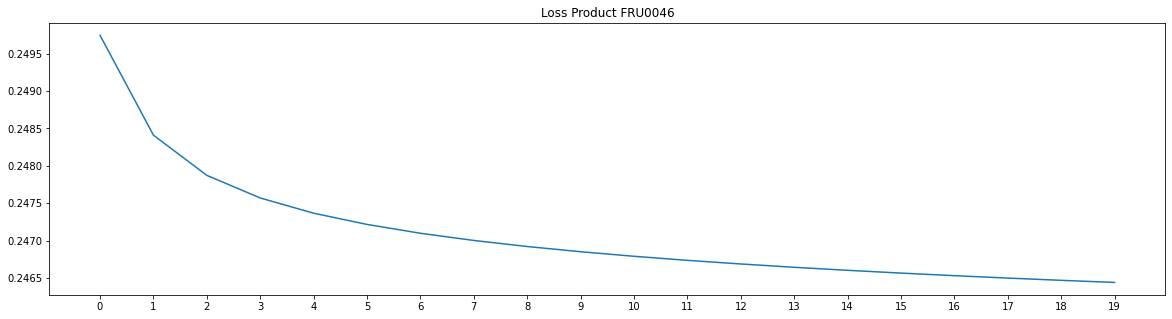

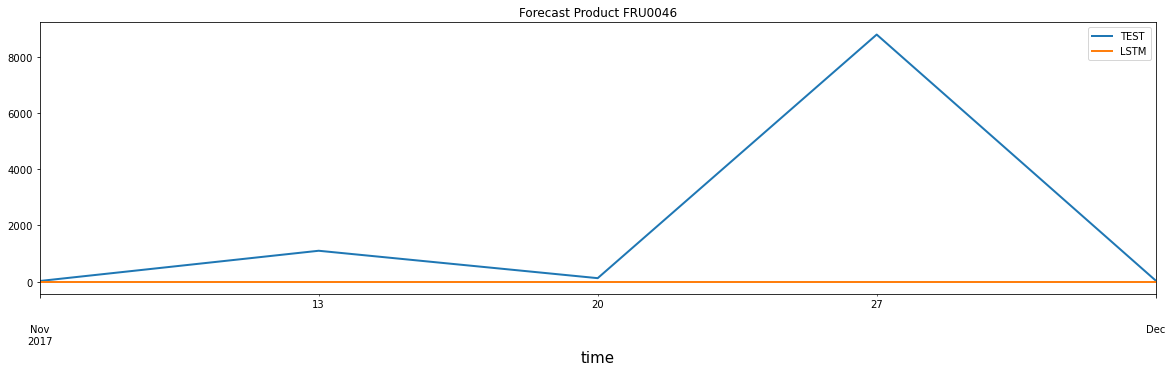

    SI rolling forecast -> Test RMSE: 3966.543810422368
    NO rolling forecast -> Test RMSE: 15733469.8


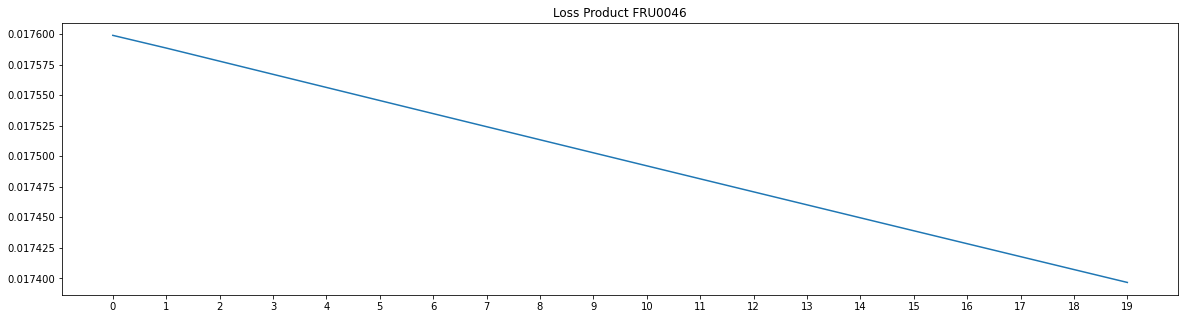

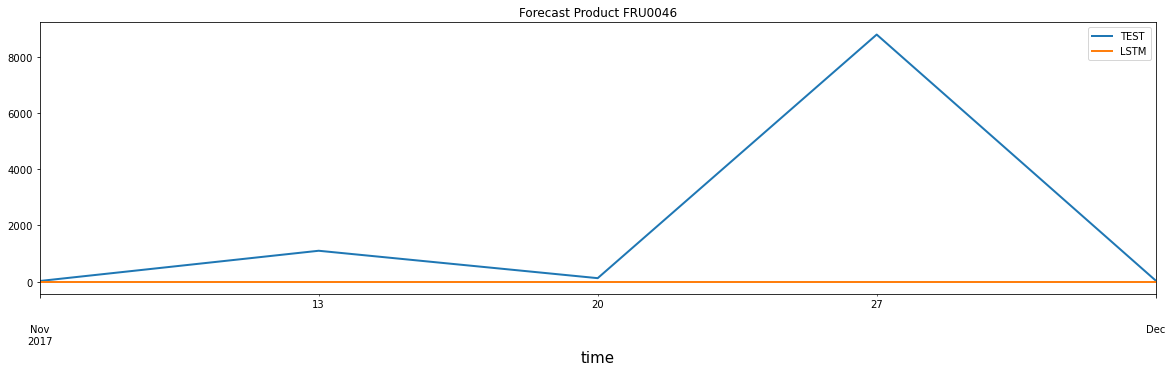

    SI rolling forecast -> Test RMSE: 3966.543810422368
    NO rolling forecast -> Test RMSE: 15733469.8


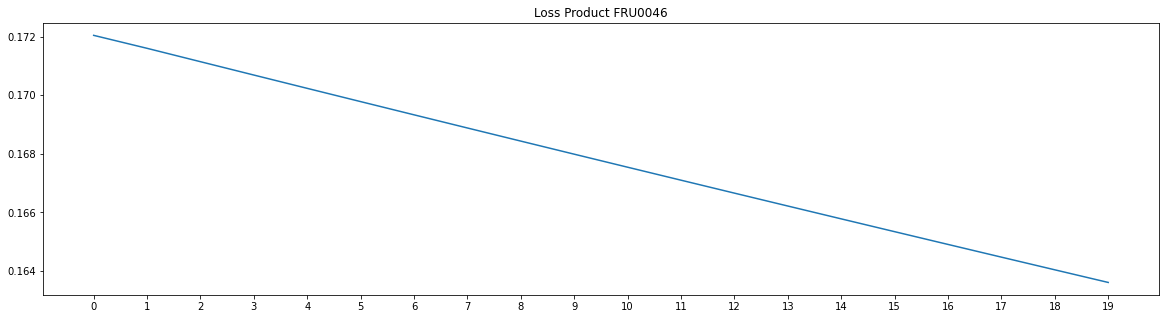

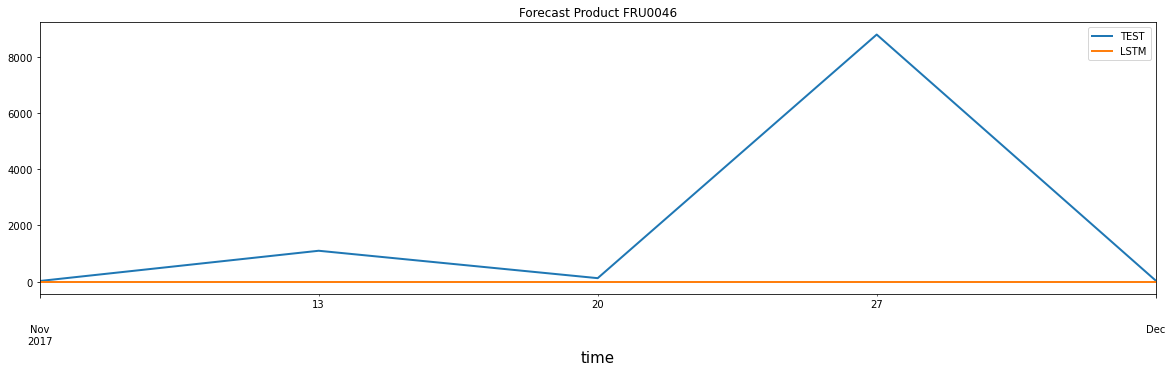

    SI rolling forecast -> Test RMSE: 3966.543810422368
    NO rolling forecast -> Test RMSE: 15733469.8


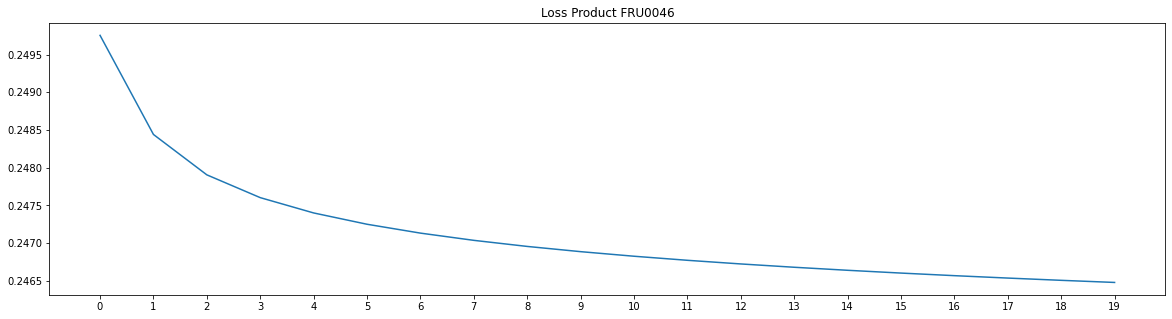

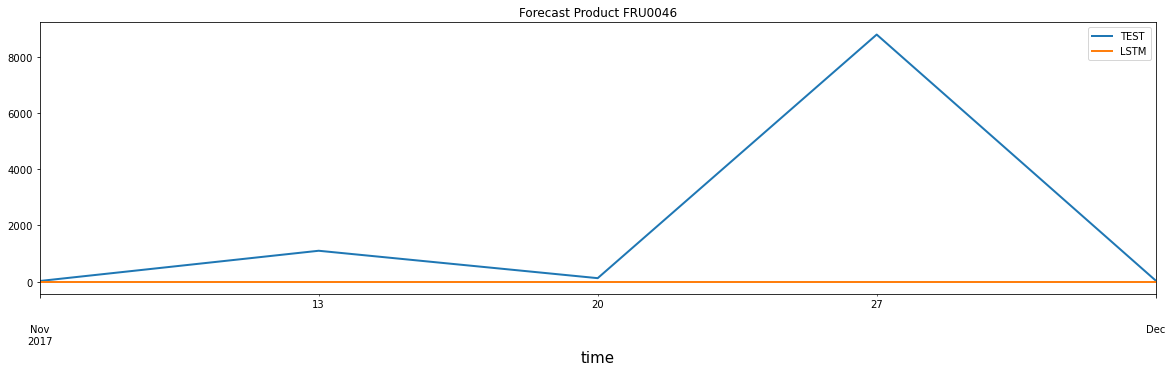

    SI rolling forecast -> Test RMSE: 3966.543810422368
    NO rolling forecast -> Test RMSE: 15733469.8


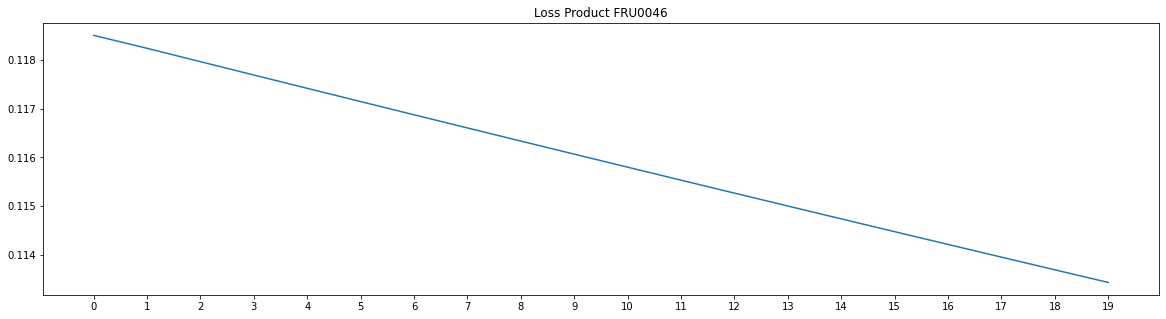

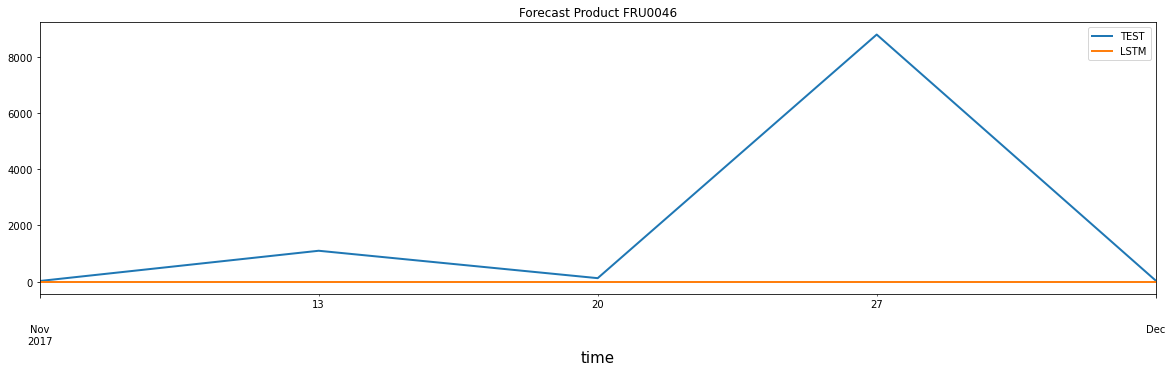

    SI rolling forecast -> Test RMSE: 3966.543810422368
    NO rolling forecast -> Test RMSE: 15733469.8


[I 2020-10-13 12:21:49,665] Trial 1 finished with value: 7868718.171905211 and parameters: {'epocas': 20, 'n_layers': 3, 'layer_Bidirectional_0_n_units': 12, 'layer_Bidirectional_1_n_units': 5, 'layer_Bidirectional_2_n_units': 7, 'layer_Bidirectional_n_units': 14, 'layer_Dense_0_n_units': 78, 'layer_Dense_0_activation': 'selu', 'layer_Dense_1_n_units': 41, 'layer_Dense_1_activation': 'selu', 'layer_Dense_2_n_units': 18, 'layer_Dense_2_activation': 'sigmoid', 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0019520208592180952, 'sgd_opt_momentum': 0.0358259234756394}. Best is trial 1 with value: 7868718.171905211.


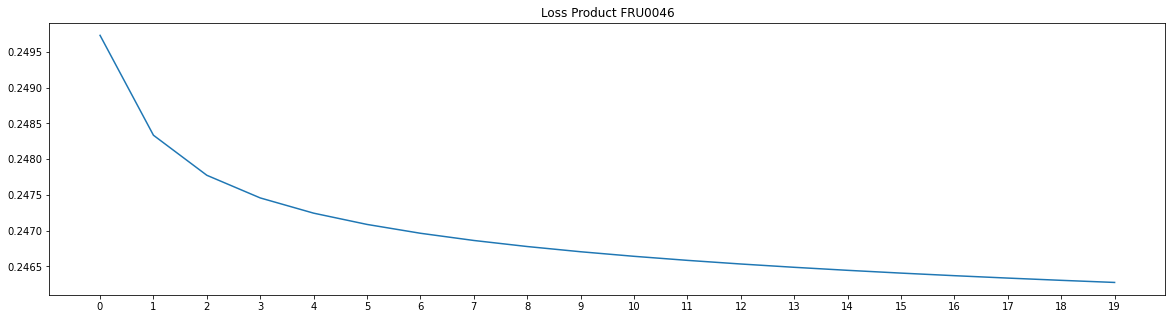

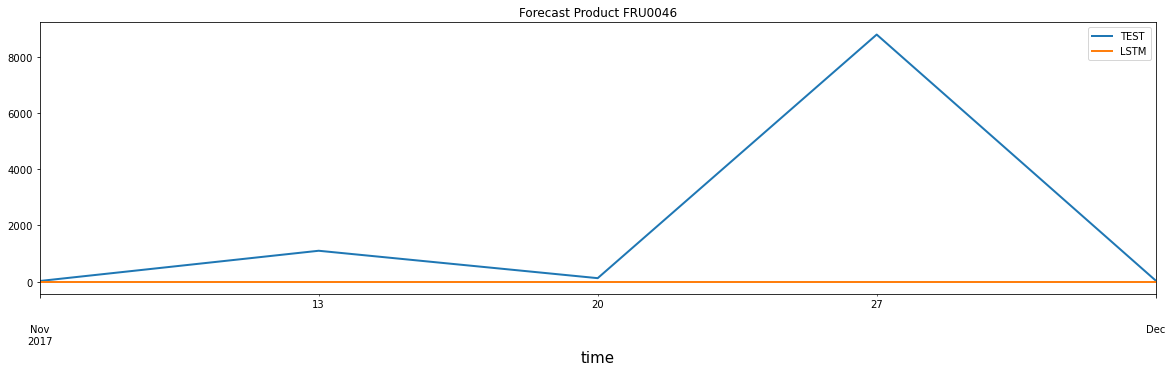

    SI rolling forecast -> Test RMSE: 3966.543810422368
    NO rolling forecast -> Test RMSE: 15733469.8


[I 2020-10-13 12:22:05,344] Trial 0 finished with value: 7868718.171905211 and parameters: {'epocas': 20, 'n_layers': 4, 'layer_Bidirectional_0_n_units': 13, 'layer_Bidirectional_1_n_units': 7, 'layer_Bidirectional_2_n_units': 5, 'layer_Bidirectional_3_n_units': 8, 'layer_Bidirectional_n_units': 9, 'layer_Dense_0_n_units': 67, 'layer_Dense_0_activation': 'tanh', 'layer_Dense_1_n_units': 101, 'layer_Dense_1_activation': 'tanh', 'layer_Dense_2_n_units': 94, 'layer_Dense_2_activation': 'selu', 'layer_Dense_3_n_units': 30, 'layer_Dense_3_activation': 'tanh', 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 8.095581788588172e-05, 'rmsprop_decay': 0.871227227087298, 'rmsprop_momentum': 0.006353894974291295}. Best is trial 1 with value: 7868718.171905211.


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Best trial:
  Value:  7868718.171905211
  Params: 
    epocas: 20
    n_layers: 3
    layer_Bidirectional_0_n_units: 12
    layer_Bidirectional_1_n_units: 5
    layer_Bidirectional_2_n_units: 7
    layer_Bidirectional_n_units: 14
    layer_Dense_0_n_units: 78
    layer_Dense_0_activation: selu
    layer_Dense_1_n_units: 41
    layer_Dense_1_activation: selu
    layer_Dense_2_n_units: 18
    layer_Dense_2_activation: sigmoid
    optimizer: SGD
    sgd_opt_learning_rate: 0.0019520208592180952
    sgd_opt_momentum: 0.0358259234756394


## Corriendo el producto: VER0035

Producto número: 2 , Total de productos: 6 , avance: 33.0%


[I 2020-10-13 12:22:05,605] A new study created in memory with name: Optuna_BRNN_Study_Producto_VER0035


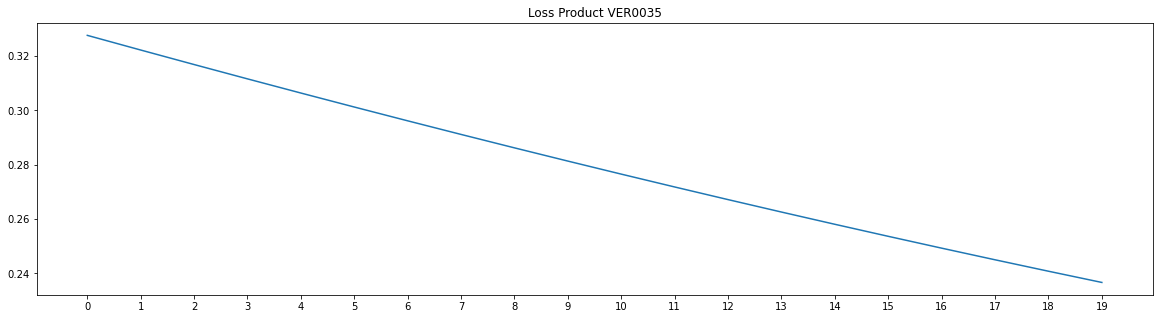

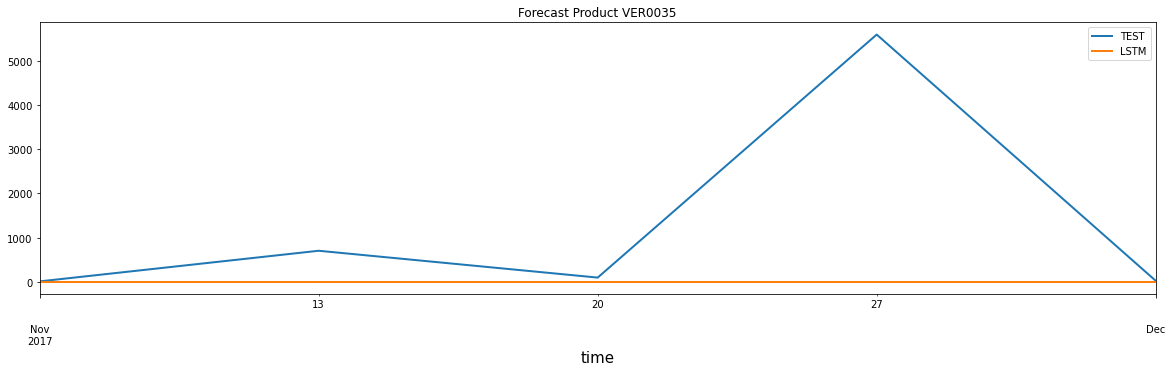

    SI rolling forecast -> Test RMSE: 2524.238499032926
    NO rolling forecast -> Test RMSE: 6371780.0


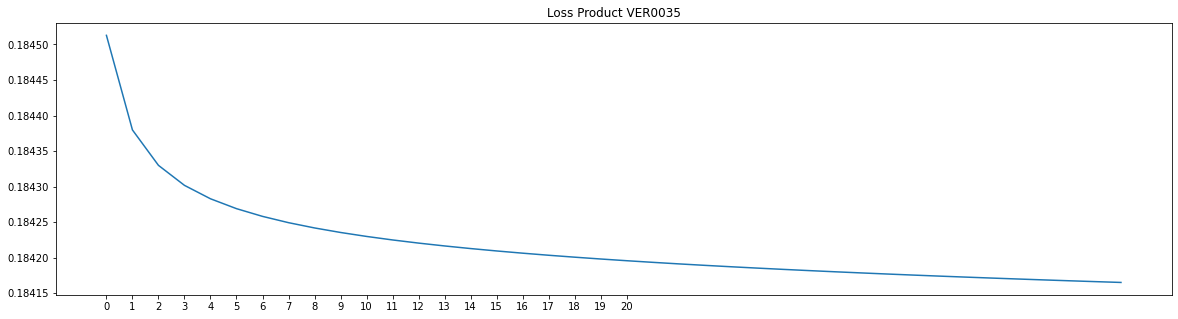

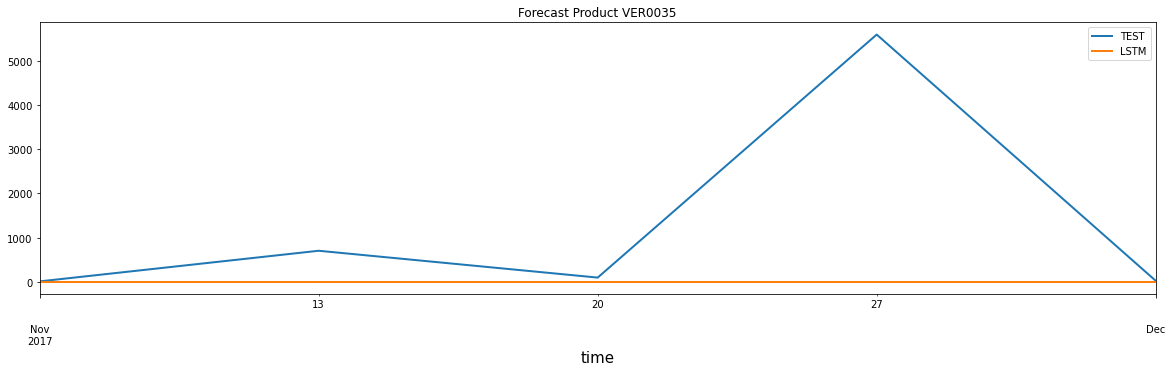

    SI rolling forecast -> Test RMSE: 2524.238499032926
    NO rolling forecast -> Test RMSE: 6371780.0


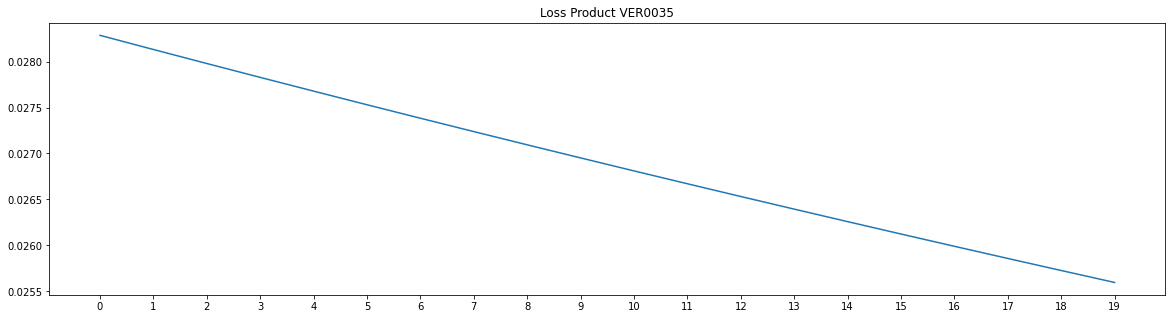

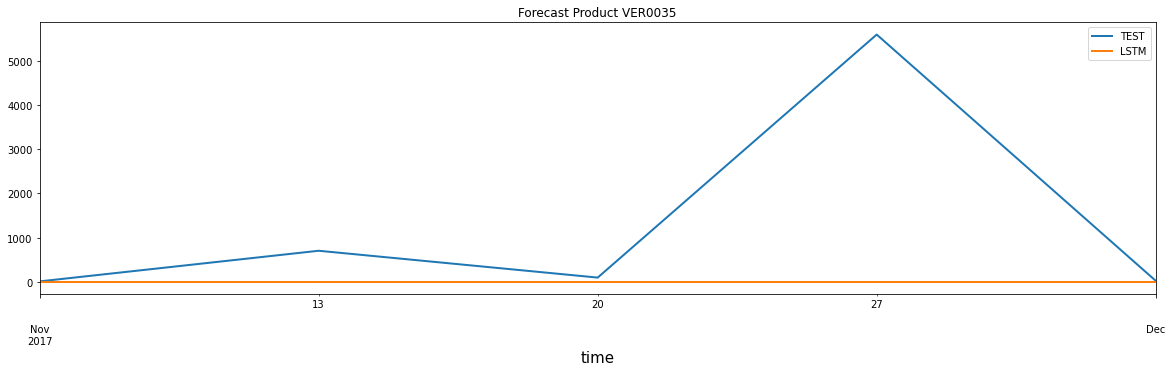

    SI rolling forecast -> Test RMSE: 2524.238499032926
    NO rolling forecast -> Test RMSE: 6371780.0


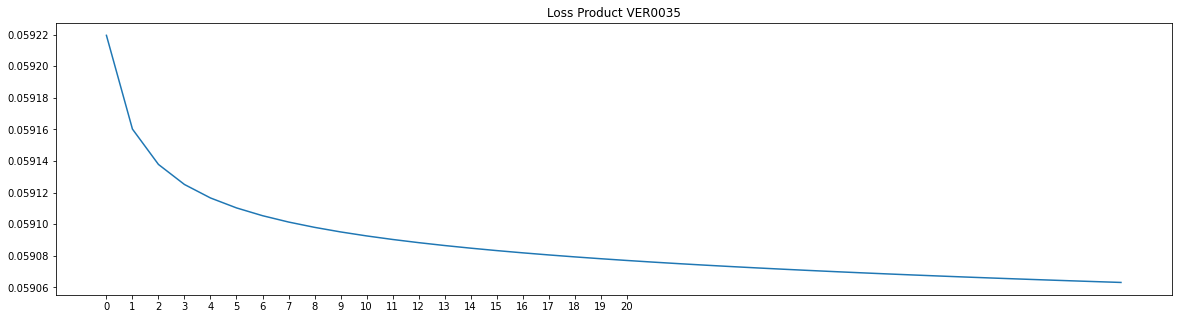

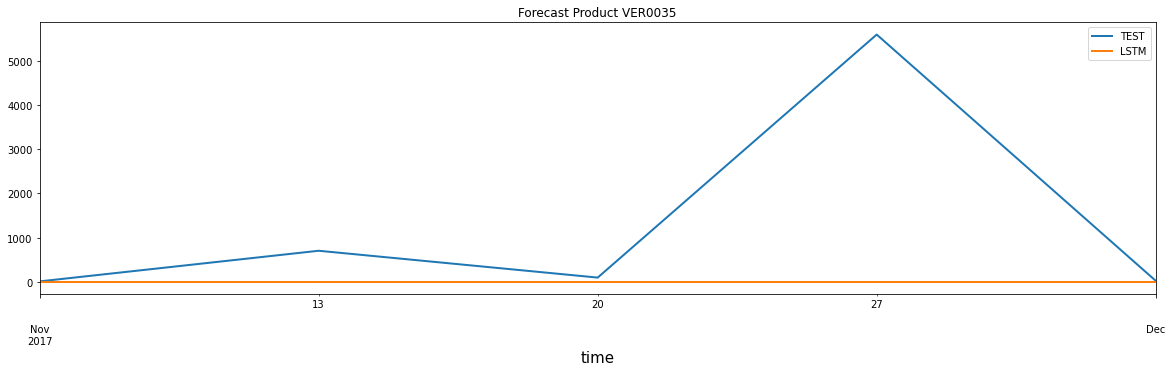

    SI rolling forecast -> Test RMSE: 2524.238499032926
    NO rolling forecast -> Test RMSE: 6371780.0


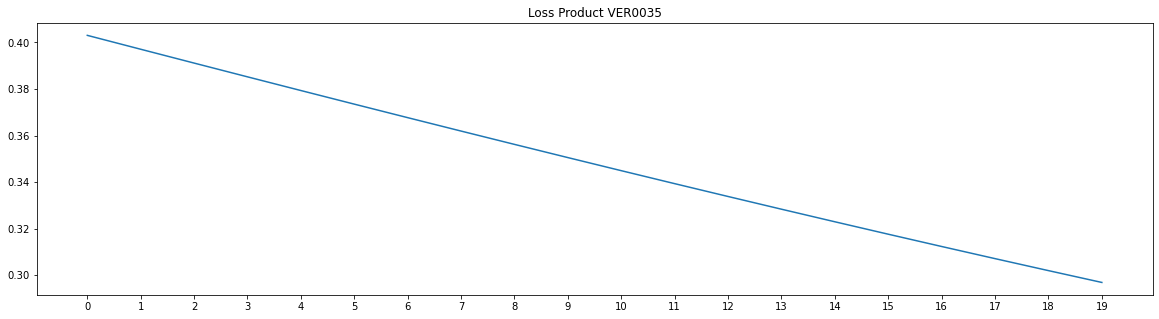

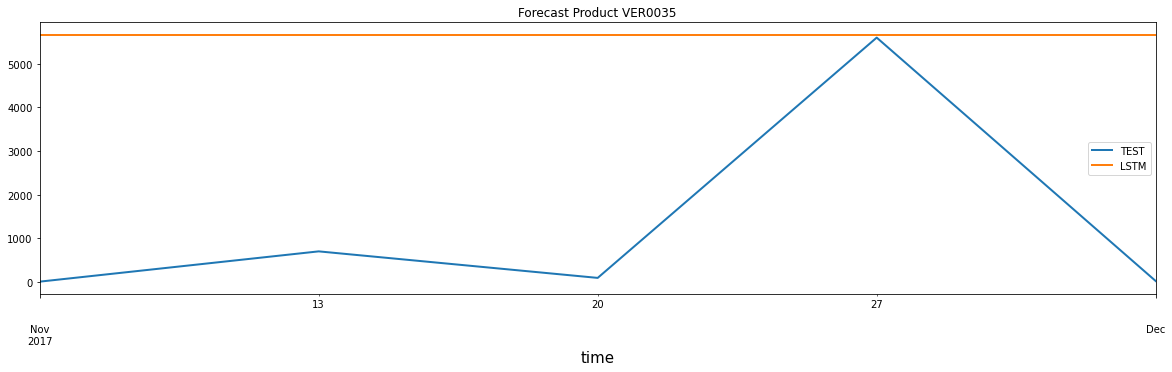

    SI rolling forecast -> Test RMSE: 4895.370874612056
    NO rolling forecast -> Test RMSE: 23964656.0


[I 2020-10-13 12:24:01,671] Trial 0 finished with value: 11984775.685437307 and parameters: {'epocas': 20, 'n_layers': 1, 'layer_Bidirectional_0_n_units': 44, 'layer_Bidirectional_n_units': 15, 'layer_Dense_0_n_units': 16, 'layer_Dense_0_activation': 'sigmoid', 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.013491845708804334, 'sgd_opt_momentum': 2.0304270992911448e-05}. Best is trial 0 with value: 11984775.685437307.


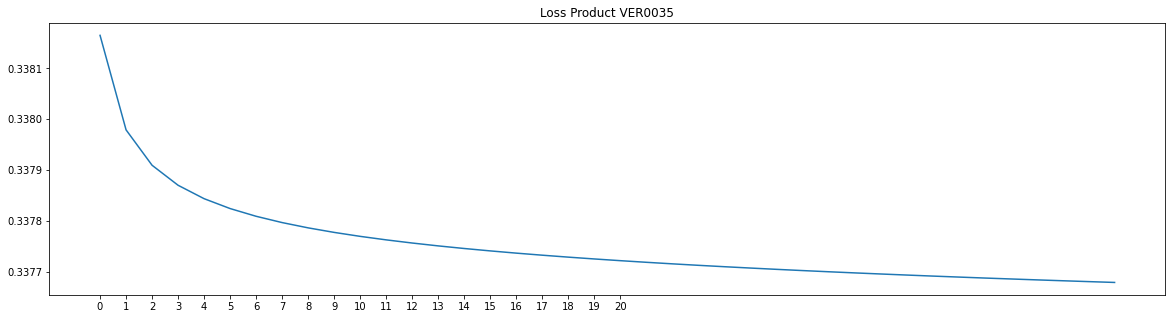

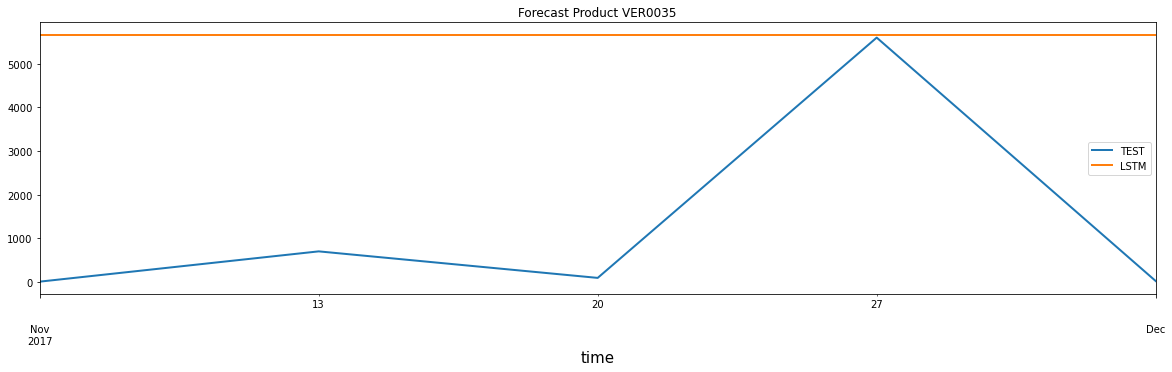

    SI rolling forecast -> Test RMSE: 4895.370874612056
    NO rolling forecast -> Test RMSE: 23964656.0


[I 2020-10-13 12:24:15,278] Trial 1 finished with value: 11984775.685437307 and parameters: {'epocas': 40, 'n_layers': 1, 'layer_Bidirectional_0_n_units': 59, 'layer_Bidirectional_n_units': 36, 'layer_Dense_0_n_units': 13, 'layer_Dense_0_activation': 'sigmoid', 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.967464150637898e-05, 'rmsprop_decay': 0.9575422558139457, 'rmsprop_momentum': 0.00011249135697228119}. Best is trial 0 with value: 11984775.685437307.


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Best trial:
  Value:  11984775.685437307
  Params: 
    epocas: 20
    n_layers: 1
    layer_Bidirectional_0_n_units: 44
    layer_Bidirectional_n_units: 15
    layer_Dense_0_n_units: 16
    layer_Dense_0_activation: sigmoid
    optimizer: SGD
    sgd_opt_learning_rate: 0.013491845708804334
    sgd_opt_momentum: 2.0304270992911448e-05


## Corriendo el producto: VER0038

Producto número: 3 , Total de productos: 6 , avance: 50.0%


[I 2020-10-13 12:24:15,373] A new study created in memory with name: Optuna_BRNN_Study_Producto_VER0038


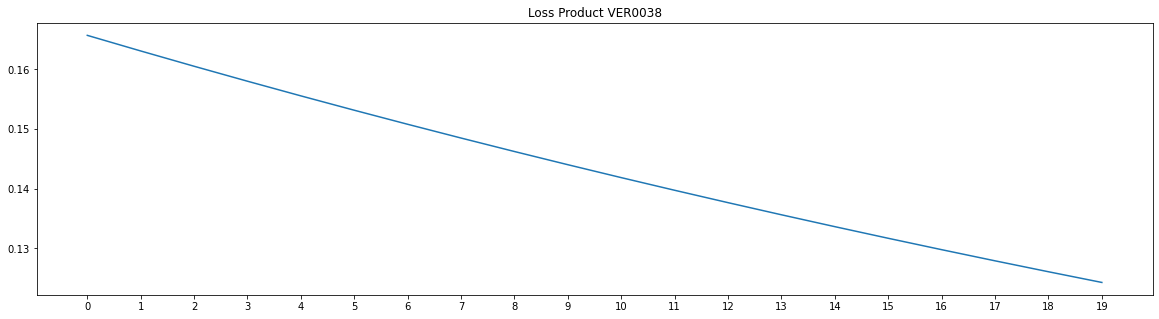

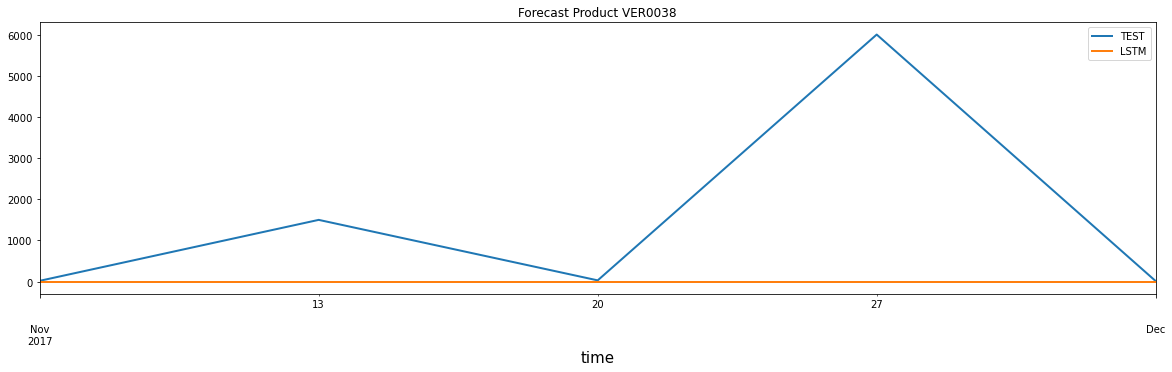

    SI rolling forecast -> Test RMSE: 2765.918653901448
    NO rolling forecast -> Test RMSE: 7650306.0


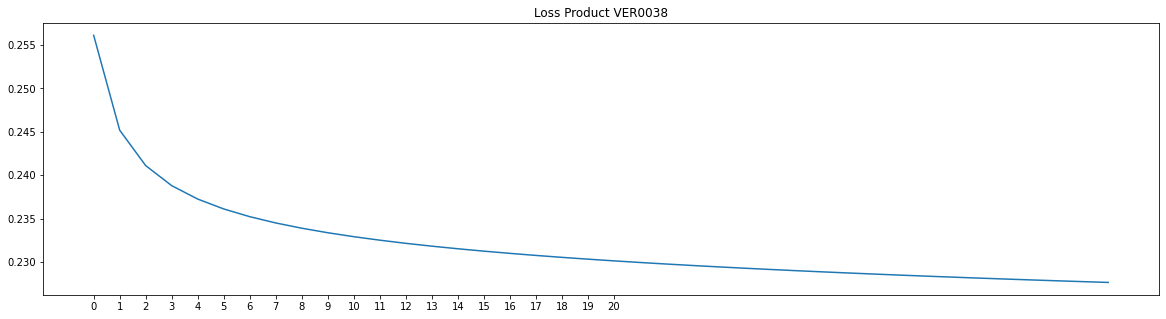

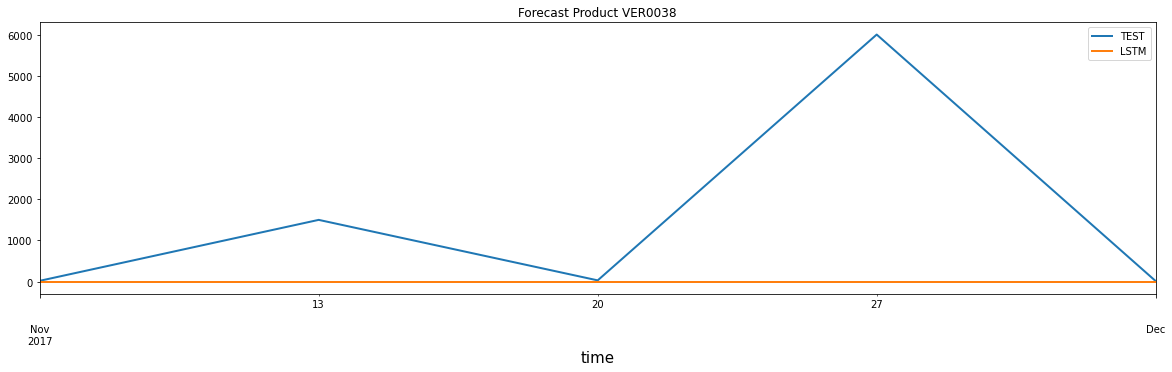

    SI rolling forecast -> Test RMSE: 2765.918653901448
    NO rolling forecast -> Test RMSE: 7650306.0


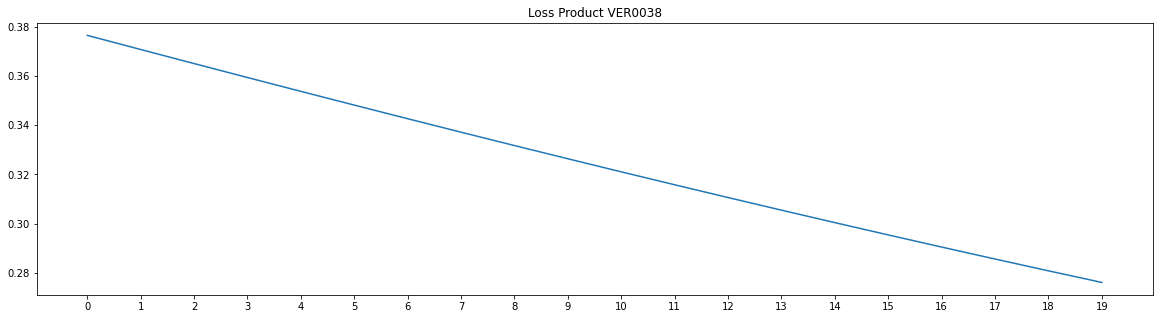

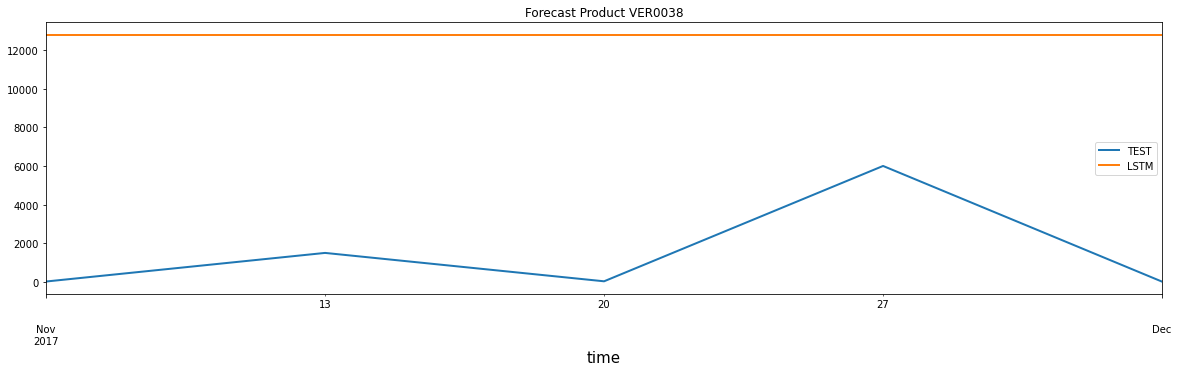

    SI rolling forecast -> Test RMSE: 11522.266530505185
    NO rolling forecast -> Test RMSE: 132762626.0


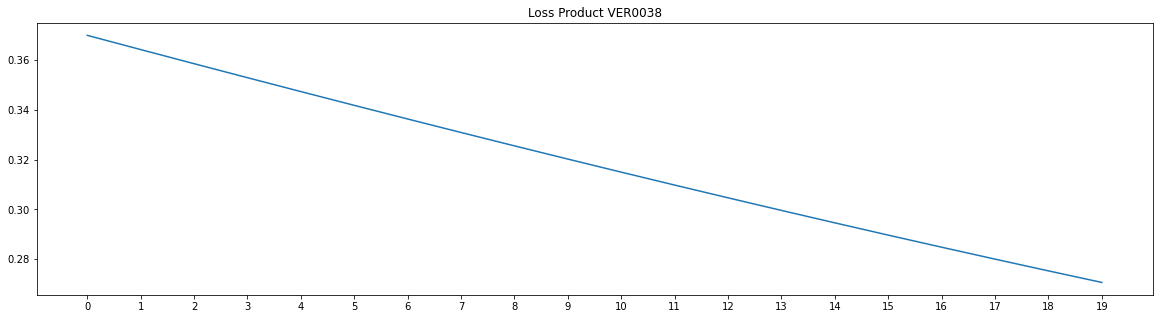

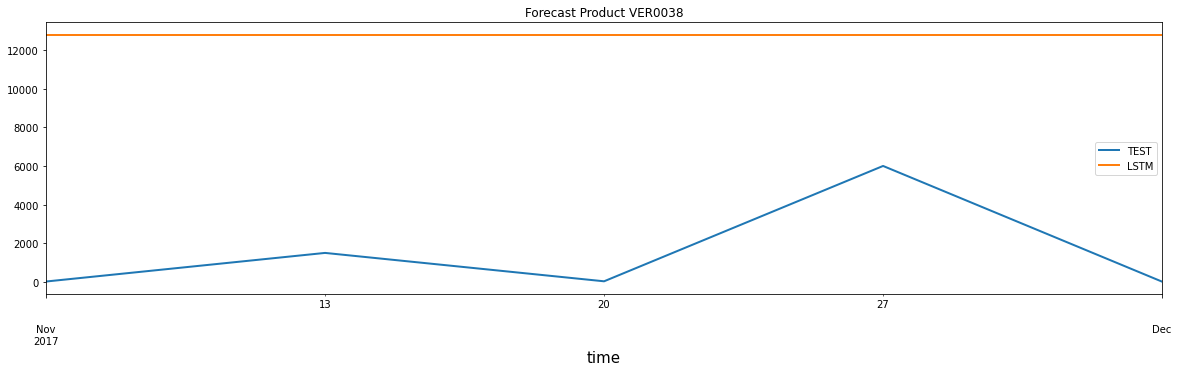

    SI rolling forecast -> Test RMSE: 11522.266530505185
    NO rolling forecast -> Test RMSE: 132762626.0


[I 2020-10-13 12:27:15,743] Trial 1 finished with value: 66387074.13326525 and parameters: {'epocas': 20, 'n_layers': 2, 'layer_Bidirectional_0_n_units': 14, 'layer_Bidirectional_1_n_units': 54, 'layer_Bidirectional_n_units': 5, 'layer_Dense_0_n_units': 6, 'layer_Dense_0_activation': 'selu', 'layer_Dense_1_n_units': 46, 'layer_Dense_1_activation': 'sigmoid', 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0053965176294859295, 'sgd_opt_momentum': 0.0001058974570389241}. Best is trial 1 with value: 66387074.13326525.


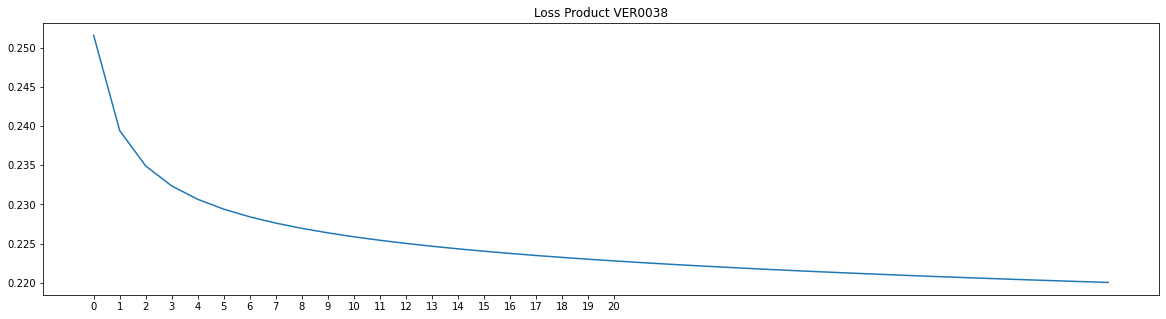

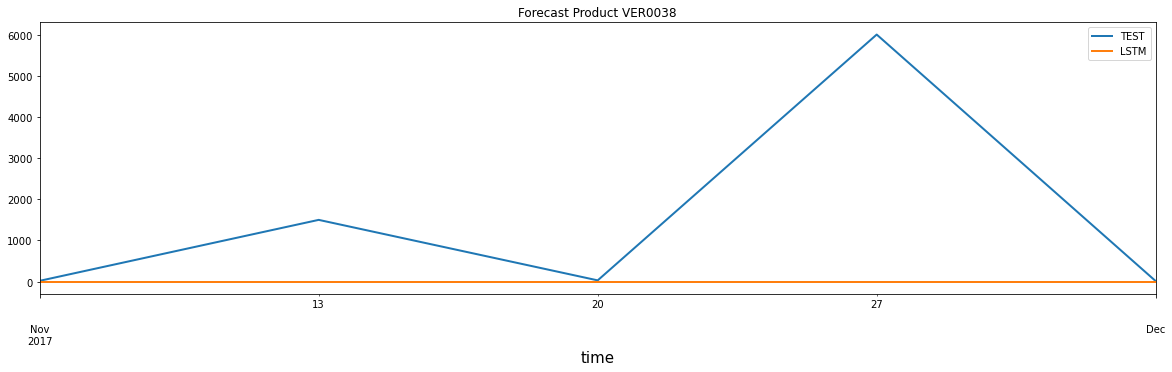

    SI rolling forecast -> Test RMSE: 2765.918653901448
    NO rolling forecast -> Test RMSE: 7650306.0


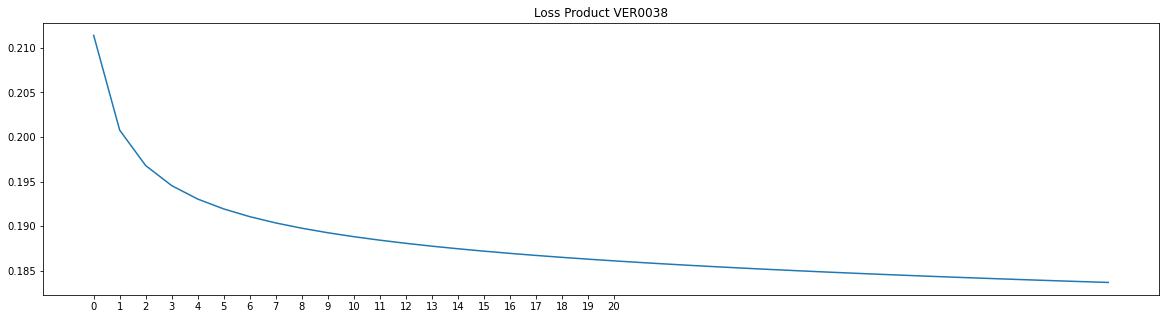

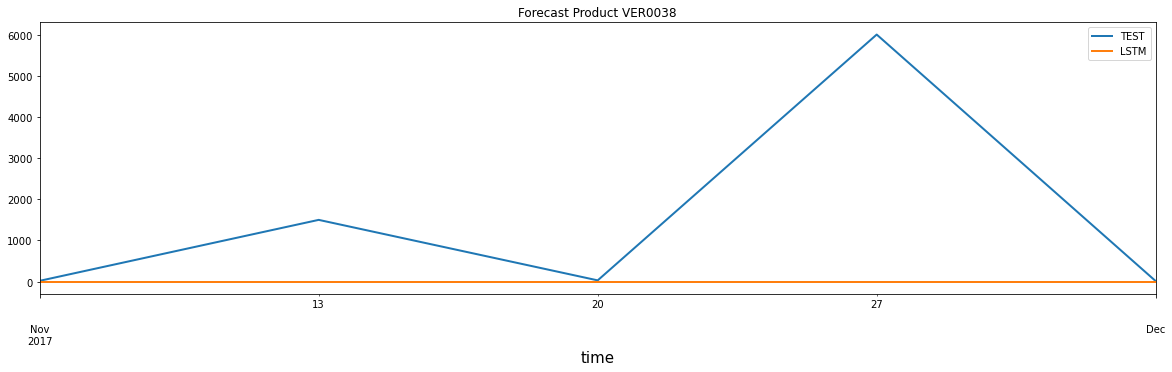

    SI rolling forecast -> Test RMSE: 2765.918653901448
    NO rolling forecast -> Test RMSE: 7650306.0


[I 2020-10-13 12:28:20,402] Trial 0 finished with value: 3826535.959326951 and parameters: {'epocas': 40, 'n_layers': 4, 'layer_Bidirectional_0_n_units': 8, 'layer_Bidirectional_1_n_units': 30, 'layer_Bidirectional_2_n_units': 38, 'layer_Bidirectional_3_n_units': 5, 'layer_Bidirectional_n_units': 13, 'layer_Dense_0_n_units': 12, 'layer_Dense_0_activation': 'tanh', 'layer_Dense_1_n_units': 97, 'layer_Dense_1_activation': 'sigmoid', 'layer_Dense_2_n_units': 9, 'layer_Dense_2_activation': 'sigmoid', 'layer_Dense_3_n_units': 85, 'layer_Dense_3_activation': 'tanh', 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0001976777876269692, 'rmsprop_decay': 0.9049073019112591, 'rmsprop_momentum': 3.216628198221879e-05}. Best is trial 0 with value: 3826535.959326951.


Study statistics: 
  Number of finished trials:  2
  Number of pruned trials:  0
  Number of complete trials:  2
Best trial:
  Value:  3826535.959326951
  Params: 
    epocas: 40
    n_layers: 4
    layer_Bidirectional_0_n_units: 8
    layer_Bidirectional_1_n_units: 30
    layer_Bidirectional_2_n_units: 38
    layer_Bidirectional_3_n_units: 5
    layer_Bidirectional_n_units: 13
    layer_Dense_0_n_units: 12
    layer_Dense_0_activation: tanh
    layer_Dense_1_n_units: 97
    layer_Dense_1_activation: sigmoid
    layer_Dense_2_n_units: 9
    layer_Dense_2_activation: sigmoid
    layer_Dense_3_n_units: 85
    layer_Dense_3_activation: tanh
    optimizer: RMSprop
    rmsprop_learning_rate: 0.0001976777876269692
    rmsprop_decay: 0.9049073019112591
    rmsprop_momentum: 3.216628198221879e-05


## Corriendo el producto: VER0010

Producto número: 4 , Total de productos: 6 , avance: 67.0%


[I 2020-10-13 12:28:20,643] A new study created in memory with name: Optuna_BRNN_Study_Producto_VER0010


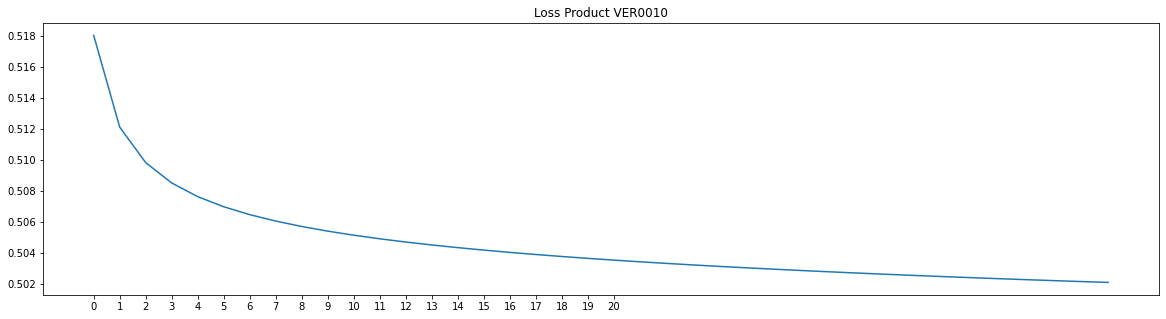

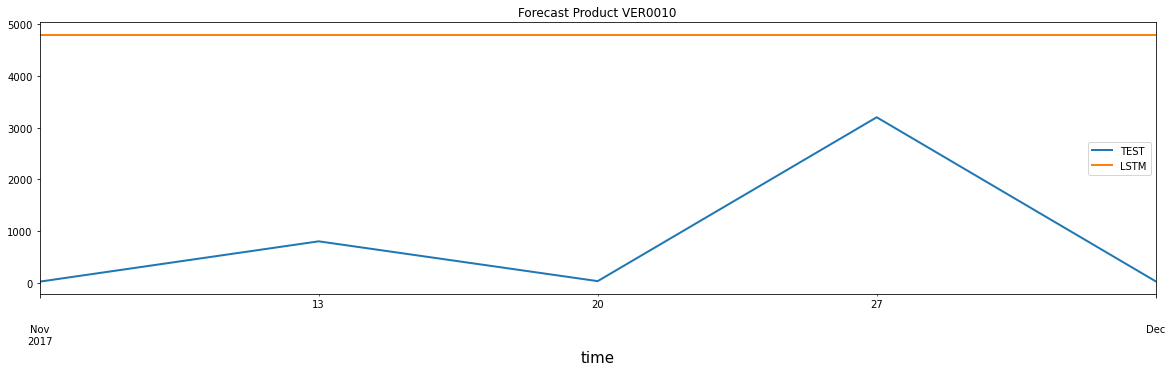

    SI rolling forecast -> Test RMSE: 4170.1888686245375
    NO rolling forecast -> Test RMSE: 17390475.2


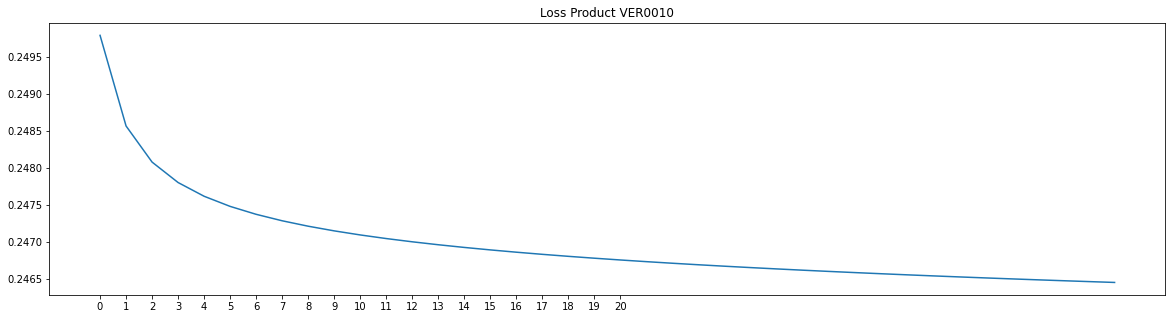

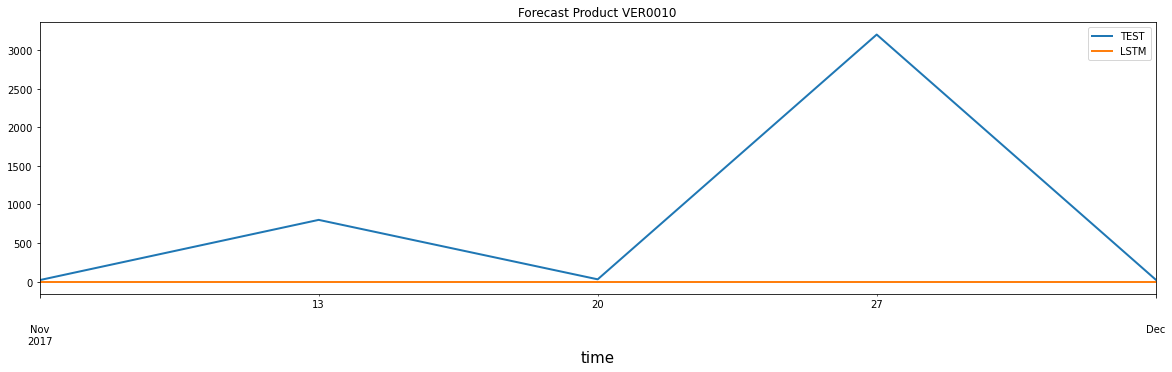

    SI rolling forecast -> Test RMSE: 1475.2610616429895
    NO rolling forecast -> Test RMSE: 2176395.2


In [ ]:
Producto_no = 0
for Producto in Productos: 
    Producto_no += 1
    display(Markdown("## Corriendo el producto: " + Producto))
    print(f'Producto número: {Producto_no} , Total de productos: {len(Productos)} , avance: {round(Producto_no/len(Productos), 2)*100}%')
    # Filtrando por producto
    temp = pedidos_producto(Producto)
    pickle.dump(temp, open(os.path.join('../temp/temp.dat'), 'wb'))
    pickle.dump(Producto, open(os.path.join('../temp/Producto.dat'), 'wb'))
    pickle.dump(Error, open(os.path.join('../temp/Error.dat'), 'wb'))

    run_study(f'Study_Producto_{Producto}')
    #break